NESTML sequence learning network
================================

*Much of this text is directly based on and excerpted from the PhD thesis of Younes Bouhadjar [1]_.*

<a name="introduction"></a>

Introduction
------------

In this tutorial, a neuron and synapse model are defined in NESTML that are subsequently used in a network to perform learning, prediction and replay of sequences of items, such as letters, images or sounds [2]. Sequence elements are represented by Latin characters (A, B, C, ...).

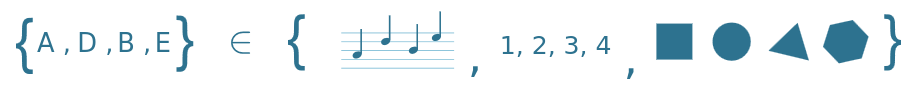

The architecture learns sequences in a continuous manner: the network is exposed to repeated presentations of a given ensemble of sequences (e.g., {A,D,B,E} and {F,D,B,C}). At the beginning of the learning process, all presented sequence elements are unanticipated and do not lead to a prediction. As a consequence, the network generates mismatch signals and adjusts its synaptic strengths to minimise the prediction error.

There is a distinction between a training phase and a replay phase. During training, the network is exposed to the sequences that we want it to learn. In replay mode, the network autonomously replays learned sequences in response to a cue signal, and synaptic weights are fixed.

In general, the sequences can be "high-order" (similar to those generated by a high-order Markov chain), where the prediction of an upcoming sequence element requires accounting for not just the previous element, but for (parts of) the entire sequence history or context. Sequences within a given set of training data can be partially overlapping; they may share certain elements or subsequences (such as in {A,D,B,E} and {F,D,B,C}), and the same sequence element (but not the first one) may occur multiple times within the same sequence (such as in {A,D,B,D}).

Network structure
------------------

The network consists of a population E of $N_\text{E}$ excitatory neurons, and a population I of $N_\text{I}$ inhibitory neurons. The neurons in E are randomly and recurrently connected, such that each neuron in E receives $K_\text{EE}$ excitatory inputs from other randomly chosen neurons in E. These "EE" connections are potential connections in the sense that they can be either "mature" ("effective") or "immature". Immature connections have no effect on target neurons. (More details to follow in the section about the synapse model below.)

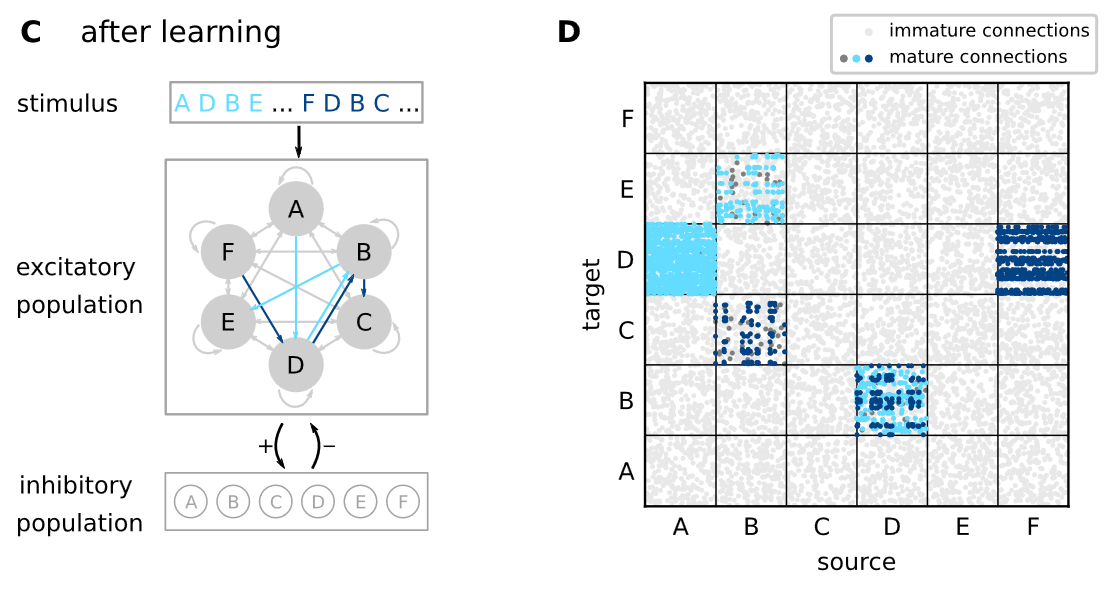

The excitatory population E is subdivided into $M$ non-overlapping subpopulations $M_1, \ldots, M_M$, each of them containing neurons with identical stimulus preference ("receptive field"). Each subpopulation $M_k$ thereby represents a specific element within a sequence. The number $M$ of subpopulations is equal to the number of elements required for a specific set of sequences, such that each sequence element is encoded by exactly one subpopulation.

All neurons within a subpopulation $M_k$ are recurrently connected to a subpopulation-specific inhibitory neuron $k$ in I. The inhibitory neurons in I are mutually unconnected. The subdivision of excitatory neurons into stimulus-specific subpopulations defines how external inputs are fed to the network, but does not affect the potential excitatory connectivity, which is homogeneous and not subpopulation specific.

#### External inputs

During training mode, the network is driven by an ensemble $X = \{x_1, \ldots, x_M\}$ of $M$ external inputs, representing inputs from other brain areas, such as thalamic sources or other cortical areas. Each of these external inputs $x_k$ represents a specific sequence element ("A", "B", ...), and feeds all neurons in the subpopulation $M_k$ with the corresponding stimulus preference. The occurrence of a specific sequence element $\zeta_{i,j}$ at time $t_{i,j}$ is modeled by a single spike $x_k(t) = \delta(t − t_{i,j})$ generated by the corresponding external source $x_k$. Subsequent sequences $s_i$ and $s_{i+1}$ are separated in time by an inter-sequence time interval $\Delta T_\text{seq}$.

During replay mode, we present only a cue signal encoding for first sequence elements $\zeta_{i,1}$ at times $t_{i,1}$. Subsequent cues are separated in time with an inter-cue time interval $\Delta T_\text{cue}$

In the absence of any other (inhibitory) inputs, each external input spike is strong enough to evoke an immediate response spike in all target neurons in $M_k$. An external input strongly depolarizes the neurons and causes them to fire. To this end, the external weights $J_\text{EX}$ are chosen to be supra-threshold. Sparse activation of the subpopulations in response to the external inputs is achieved by a winner-take-all mechanism implemented in the form of inhibitory feedback.

#### Neuron model

The dendrites are grouped into distal and proximal dendrites. Distal dendrites receive inputs from other neurons in the local network, whereas proximal dendrites are activated by external sources. Inputs to proximal dendrites have a large effect on the soma and trigger the generation of action potentials. Individual synaptic inputs to a distal dendrite, in contrast, have no direct effect on the soma. If the total synaptic input to a distal dendritic branch at a given time step is sufficiently large, the neuron becomes predictive. This dynamic mimics the generation of dendritic action potentials (dAPs): NMDA spikes which result in a long-lasting depolarization (∼50-500ms) of the somata of neocortical pyramidal neurons.

The temporal evolution of the membrane potential is given by the leaky integrate-and-fire model:

$$
\tau_{\text{m},i} \frac{d V_{\text{m},i}(t)}{dt} = -V_{\text{m},i}(t) + R_{\text{m},i} I_i(t)
$$

with membrane resistance $R_{\text{m},i} = \tau_{\text{m},i} C_{\text{m},i}$, membrane time constant $\tau_{\text{m},i}$, and total synaptic input current $I_i(t)$.

The total synaptic input current of excitatory neurons is composed of currents in distal dendritic branches, inhibitory currents, and currents from external sources. Inhibitory neurons receive only inputs from excitatory neurons in the same subpopulation. 

Total synaptic input currents:

- excitatory neurons: $I_i(t) = I_{\text{ED},i}(t) + I_{\text{EX},i}(t) + I_{\text{EI},i}(t)$ for all $i \in E$
- inhibitory neurons: $I_i(t) = I_{\text{IE},i}(t)$ for all $i \in I$

Individual spikes arriving at dendritic branches evoke alpha-shaped postsynaptic currents. All dendritic input currents $I_{\text{ED},i}(t)$ evolve according to

$$
I_{\text{ED},i} = \sum_{j\in E} (\alpha_{i,j} \ast s_j)(t - d_{ij})
$$

with 

$$
\alpha_{i,j}(t) = J_{i,j} \frac{e}{\tau_\text{ED}} t e^{-t / \tau_\text{ED}} \Theta(t)
$$

and

$$
\Theta(t)=\begin{cases} 
1 & \text{if $t \geq 0$} \\
0 & \text{else}
\end{cases}
$$

All external, inhibitory and excitatory input currents $I_{\text{EX},i}(t), I_{\text{EI},i}(t), I_{\text{IE},i}(t)$ evolve according to

$$
\begin{align*}
\tau_\text{EX} \frac{I_{\text{EX},i}}{dt} &= -I_{\text{EX},i}(t) + \sum_{j\in X} J_{i,j} s_j (t - d_{i,j})\\
\tau_\text{EI} \frac{I_{\text{EI},i}}{dt} &= -I_{\text{EX},i}(t) + \sum_{j\in I} J_{i,j} s_j (t - d_{i,j})\\
\tau_\text{IE} \frac{I_{\text{IE},i}}{dt} &= -I_{\text{EX},i}(t) + \sum_{j\in E} J_{i,j} s_j (t - d_{i,j})\\
\end{align*}
$$

The dendritic current includes an additional nonlinearity describing the generation of dAPs: if the dendritic current $I_\text{ED}$ exceeds a threshold $\theta_\text{dAP}$, it is instantly set to a the dAP plateau current $I_\text{dAP}$, and clamped to this value for a period of duration $\tau_\text{dAP}$. This plateau current leads
to a long lasting depolarization of the soma.

The NESTML model description for the neuron can be found in the file ``doc/tutorials/sequences/iaf_psc_exp_nonlineardendrite_neuron.nestml``.

#### Synaptic plasticity model

Excitatory connectivity between excitatory neurons (EE connectivity) is dynamic and shaped by a Hebbian structural plasticity mechanism mimicking principles known from the neuroscience literature. All other connections are static. 

The dynamics of the EE connectivity is determined by the time evolution of the permanences $P_{i,j}$ ($i, j \in \text{E}$), representing the synapse maturity, and the synaptic weights $J_{i,j}$. Unless the permanence $P_{i,j}$ exceeds a threshold $\theta_\text{P}$, the synapse $j\rightarrow i$ is immature, with zero synaptic weight $J_{i,j} = 0$. Upon threshold crossing, $P_{i,j} \geq \theta_\text{P}$, the synapse becomes mature, and its weight is assigned a fixed value $J_{i,j} = W$.

Overall, the permanences evolve according to a Hebbian plasticity rule: the synapse $j \rightarrow i$ is potentiated, that is, $P_{i,j}$ is increased, if the activation of the postsynaptic cell $i$ is immediately preceded by an activation of the presynaptic cell $j$.

A homeostatic mechanism controlled by the postsynaptic dAP rate regulates synapse growth based on the rate of postsynaptic dAPs. This form of homeostasis prevents the same neuron from becoming predictive multiple times within the same set of sequences, and thereby reduces the overlap between subsets of neurons activated within different contexts.

Permanences $P_{i,j}(t)$ evolve according to a combination of an additive spike-timing-dependent plasticity (STDP)
rule (Morrison et al., 2008) and a homeostatic component:

$$
\begin{align}
P^{-1}_\text{max} \frac{dP_{i,j}}{dt} &= \lambda_+ \sum_{\{t_i^\ast\}'} x_j(t)\delta(t - t_i^\ast - d_\text{EE}) I(t_i^\ast, \Delta t_\text{min}, \Delta t_\text{max}) \\
&- \lambda_- \sum_{\{t_j^\ast\}} \delta(t - t_j^\ast)\\
&+\lambda_\text{h} \sum_{\{t_i^\ast\}'} (z^\ast - z_i(t)) \delta(t - t_i^\ast) I(t_i^\ast, \Delta t_\text{min}, \Delta t_\text{max})
\end{align}
$$

The first term on the right-hand side corresponds to the spike-timing-dependent synaptic potentiation triggered by the postsynaptic spikes. The indicator function $I(t^\ast_i, \Delta t_\text{min}, \Delta t_\text{max})$ ensures that the
potentiation (and the homeostasis; see below) is restricted to time lags $t_i^\ast - t_j^+ + d_\text{EE}$ in the interval $(\Delta t_\text{min}, \Delta t_\text{max})$ to avoid a growth of synapses between synchronously active neurons belonging to the same subpopulation, and between neurons encoding for the first elements in different sequences:

$$
I(t_i^\ast, \Delta t_\text{min}, \Delta t_\text{max}) = \begin{cases} 
1 & \text{if $\Delta t_\text{min} < t_i^\ast - t_j^+ + d_\text{EE} < \Delta t_\text{max}$} \\
0 & \text{else}
\end{cases}
$$

Note that the potentiation update times lag the somatic postsynaptic spike times by the delay $d_\text{EE}$, which is here interpreted as a purely dendritic delay (Morrison et al., 2007).

The potentiation increment is determined by the dimensionless potentiation rate $\lambda_+$, and the spike trace $x_j(t)$ of the presynaptic neuron $j$, which is updated according to

$$
\tau_+ \frac{dx_j}{dt} = -x_j(t) + \sum_{t_j^\ast} \delta(t - t_j^\ast)
$$

The trace $x_j(t)$ is incremented by 1 at each spike time $t^∗_j$, followed by an exponential decay with time constant $\tau_+$. The potentiation increment $\Delta P_{i,j}$ at time $t^∗_i$ therefore depends on the temporal distance between the postsynaptic spike time $t^∗_i$ and all presynaptic spike times $t^\ast_j \leq t^\ast_i$ (STDP with all-to-all spike pairing [Morrison et al. 2008]). 

The second term on the right-hand side represents synaptic depression, and is triggered by each presynaptic spike at times $t^\ast_j \in \{t^\ast_j\}$. The depression decrement is treated as a constant equal to 1, independently of the postsynaptic spike history. The depression magnitude is parameterized by the dimensionless depression rate $\lambda_-$.

The third term corresponds to a homeostatic control triggered by postsynaptic spikes at times $t^\ast_i \in \{t^\ast_i\}'$. Its overall impact is parameterized by the dimensionless homeostasis rate $\lambda_\text{h}$. The homeostatic control enhances or reduces the synapse growth depending on the dAP trace $z_i(t)$ of neuron $i$, the low-pass filtered dAP activity updated according to

$$
\tau_\text{h}\frac{dz_i}{dt} = -z_i(t) + \sum_k \delta(t - t^k_{\text{dAP},i})
$$

Synapse growth is boosted if the dAP activity $z_i(t)$ is below a target dAP activity $z^\ast$. Conversely, high dAP activity exceeding $z^\ast$ reduces the synapse growth.

While the maximum permanences $P_\text{max}$ are identical for all EE connections, the minimal permanences $P_{\text{min},i,j}$ are uniformly distributed in the interval $[P_{0,\text{min}}, P_{0,\text{max}}]$ to introduce a form of persistent heterogeneity.

The NESTML model description for the synapse can be found in the file ``models/synapses/stdsp_synapse.nestml``.

#### Connectivity

The sequence processing capabilities of the proposed network model rely on its ability to form sequence specific
subnetworks based on the skeleton provided by the random potential connectivity. On the one hand, the potential connectivity must not be too diluted to ensure that a subset of neurons representing a given sequence element can establish sufficiently many mature connections to a second subset of neurons representing the subsequent element.
On the other hand, a dense potential connectivity would promote overlap between subnetworks representing different sequences, and thereby slow down the formation of context specific subnetworks during learning.

During the learning process, the plasticity dynamics needs to establish mature connections from $\mathcal{P}_{i,j}$ to a second subset $\mathcal{P}_{i,j+1}$ of neurons in another subpopulation representing the subsequent element 
$\zeta_{i,j+1}$. For $p \geq 0.2$, the existence of the divergent-convergent connectivity motif is almost certain ($u \approx 1$). For smaller connection probabilities $p < 0.2$, the motif probability quickly vanishes. Hence, $p = 0.2$ constitutes a reasonable choice for the
potential connection probability.

## Getting started

First, import the required modules and set some plotting options:

In [1]:
%matplotlib inline

from typing import List, Optional

import matplotlib as mpl

mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = [8., 3.]

from collections import defaultdict
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import re
import sys
import time
import hashlib
import numpy as np
from pathlib import Path
from pprint import pformat
from collections import Counter

import nest
import nest.raster_plot
import parameters as para

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils
from pynestml.codegeneration.nest_tools import NESTTools

n_threads = 12  # number of threads to use for simulations. This depends on your computer hardware.
nest_verbosity = "M_ERROR"  # try "M_ALL" for debugging


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Sep 26 2024 22:44:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Generating code with NESTML

We will use a helper function to generate the C++ code for the models and build and install it as a NEST extension module. We can then load the module in the NEST kernel at runtime by calling ``nest.Install("nestmlmodule")``.

In [2]:
if 1:
    try:
        module_name, neuron_model_name, synapse_model_name = \
            NESTCodeGeneratorUtils.generate_code_for("doc/tutorials/sequence_learning/iaf_psc_exp_nonlineardendrite_neuron.nestml",
                                                     "models/synapses/stdsp_synapse.nestml",
                                                     logging_level="WARNING",
                                                     post_ports=["post_spikes", ["dAP_trace", "dAP_trace"]],
                                                     codegen_opts={"delay_variable": {"stdsp_synapse": "d"},
                                                                   "weight_variable": {"stdsp_synapse": "w"},
                                                                   "continuous_state_buffering_method": "post_spike_based"})
    except:
            
        module_name, neuron_model_name, synapse_model_name = \
            NESTCodeGeneratorUtils.generate_code_for("../../../doc/tutorials/sequence_learning/iaf_psc_exp_nonlineardendrite_neuron.nestml",
                                                     "../../../models/synapses/stdsp_synapse.nestml",
                                                     logging_level="WARNING",
                                                     post_ports=["post_spikes", ["dAP_trace", "dAP_trace"]],
                                                     codegen_opts={"delay_variable": {"stdsp_synapse": "d"},
                                                                   "weight_variable": {"stdsp_synapse": "w"},
                                                                   "continuous_state_buffering_method": "post_spike_based"})
"""module_name = "/tmp/nestml_target_68digoes/nestml_27fd8d9de14b408f9e6181b2f2310d41_module.so"
neuron_model_name = "iaf_psc_exp_nonlineardendrite_neuron_nestml__with_stdsp_synapse_nestml"
synapse_model_name = "stdsp_synapse_nestml__with_iaf_psc_exp_nonlineardendrite_neuron_nestml" """


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Sep 26 2024 22:44:51

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.


Oct 16 18:53:18 NodeManager::add_node [Info]: 
    Neuron models emitting precisely timed spikes exist: the kernel property 
    off_grid_spiking has been set to true.
    
    NOTE: Mixing precise-spiking and normal neuron models may lead to inconsistent results.
[23,iaf_psc_exp_nonlineardendrite_neuron_nestml, WARNING, [76:36;76:49]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.
[24,iaf_psc_exp_nonlineardendrite_neuron_nes

[95,stdsp_synapse_nestml__with_iaf_psc_exp_nonlineardendrite_neuron_nestml, WARNING, [20:8;20:17]]: Variable 'd' has the same name as a physical unit!
[99,stdsp_synapse_nestml__with_iaf_psc_exp_nonlineardendrite_neuron_nestml, WARNING, [20:8;20:17]]: Variable 'd' has the same name as a physical unit!
CMake Warning (dev) at CMakeLists.txt:95 (project):
  cmake_minimum_required() should be called prior to this top-level project()
  call.  Please see the cmake-commands(7) manual for usage documentation of
  both commands.
This warning is for project developers.  Use -Wno-dev to suppress it.

-- The CXX compiler identification is GNU 12.3.0
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done

-------------------------------------------------------
nestml_53df85df034a42159911f33aede126f7_module Configuration Summary
-------------------

'module_name = "/tmp/nestml_target_68digoes/nestml_27fd8d9de14b408f9e6181b2f2310d41_module.so"\nneuron_model_name = "iaf_psc_exp_nonlineardendrite_neuron_nestml__with_stdsp_synapse_nestml"\nsynapse_model_name = "stdsp_synapse_nestml__with_iaf_psc_exp_nonlineardendrite_neuron_nestml" '

Now, the NESTML models are ready to be used in a simulation.

## Experiment 1: dAP generation in the neuron model

First, let's inspect the generation of a dendritic action potential in a single neuron.

In [3]:
def psp_max_2_psc_max(psp_max, tau_m, tau_s, R_m):
    """Compute the PSC amplitude (pA) injected to get a certain PSP maximum (mV) for LIF with exponential PSCs

    Parameters
    ----------
    psp_max: float
             Maximum postsynaptic pontential
    tau_m:   float
             Membrane time constant (ms).
    tau_s:   float
             Synaptic time constant (ms).
    R_m:     float
             Membrane resistance (Gohm).

    Returns
    -------
    float
        PSC amplitude (pA).
    """

    return psp_max / (
            R_m * tau_s / (tau_s - tau_m) * (
            (tau_m / tau_s) ** (-tau_m / (tau_m - tau_s)) -
            (tau_m / tau_s) ** (-tau_s / (tau_m - tau_s))
    )
    )


In [4]:
def create_active_dendrite_parameters():
    p = para.ParameterSpace({})
    
    DELAY = 0.1
    
    p['dt'] = 0.1                                 # simulation time resolution (ms)
    p['print_simulation_progress'] = False        # print the time progress -- True can cause issues with Jupyter
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    p['soma_params']['I_e'] = 0.          # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])
    
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
    
    # neuron parameters for the inhibitory neuron
    p['inhibit_model'] = 'iaf_psc_exp'
    p['inhibit_params'] = {}
    p['inhibit_params']['C_m'] = 250.         # membrane capacitance (pF)
    p['inhibit_params']['E_L'] = 0.           # resting membrane potential (mV)
    p['inhibit_params']['I_e'] = 0.           # external DC currents (pA)
    p['inhibit_params']['V_m'] = 0.           # initial potential (mV)
    p['inhibit_params']['V_reset'] = 0.       # reset potential (mV)
    p['inhibit_params']['V_th'] = 15.         # spike threshold (mV)
    p['inhibit_params']['t_ref'] = 2.0        # refractory period
    p['inhibit_params']['tau_m'] = 5.         # membrane time constant (ms)
    p['inhibit_params']['tau_syn_ex'] = .5    # synaptic time constant of an excitatory input (ms) 
    p['inhibit_params']['tau_syn_in'] = 1.65  # synaptic time constant of an inhibitory input (ms)
    
    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['J_IE_psp'] = 1.2 * p['inhibit_params']['V_th']  # inhibitory PSP as a response to an input from E neuron
    p['J_EI_psp'] = -2 * p['soma_params']['V_th']      # somatic PSP as a response to an inhibitory input
    p['convergence'] = 5
    p['pattern_size'] = 20
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
    p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.05 #0.1                     # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace [pA]
    p['syn_dict_ee']['lambda_h'] = 0.01                        # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight
    p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
    p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.004
    
    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    # parameters of EdX synapses (external to dendrite of E neurons) 
    p['conn_dict_edx'] = {}
    p['syn_dict_edx'] = {}
    p['syn_dict_edx']['receptor_type'] = 2                    # receptor corresponding to the dendritic input
    p['syn_dict_edx']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_edx']['weight'] = 1.4 * p['soma_params']['theta_dAP']
    p['conn_dict_edx']['rule'] = 'fixed_outdegree'            # connection rule
    p['conn_dict_edx']['outdegree'] = p['pattern_size'] + 1   # outdegree
    
    # parameters for IE synapses 
    p['syn_dict_ie'] = {}
    p['syn_dict_ie']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ie']['delay'] = DELAY                        # dendritic delay
    
    # parameters for EI synapses
    p['syn_dict_ei'] = {}
    p['syn_dict_ei']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ei']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_ei']['receptor_type'] = 3                    # receptor corresponding to the inhibitory input  
    
    p['R_m_soma'] = p['soma_params']['tau_m'] / p['soma_params']['C_m']
    p['R_m_inhibit'] = p['inhibit_params']['tau_m'] / p['inhibit_params']['C_m']
    p['syn_dict_ex']['weight'] = psp_max_2_psc_max(p['J_EX_psp'], 
                                                               p['soma_params']['tau_m'], 
                                                               p['soma_params']['tau_syn1'], 
                                                               p['R_m_soma'])
    p['syn_dict_ie']['weight'] = psp_max_2_psc_max(p['J_IE_psp'], 
                                                               p['inhibit_params']['tau_m'], 
                                                               p['inhibit_params']['tau_syn_ex'], 
                                                               p['R_m_inhibit'])
    p['syn_dict_ei']['weight'] = psp_max_2_psc_max(p['J_EI_psp'], 
                                                               p['soma_params']['tau_m'], 
                                                               p['soma_params']['tau_syn3'], 
                                                               p['R_m_soma'])

    
    p['soma_excitation_time'] = 25.
    p['dendrite_excitation_time'] = 3.

    return p

p = create_active_dendrite_parameters()

The network looks as follows:

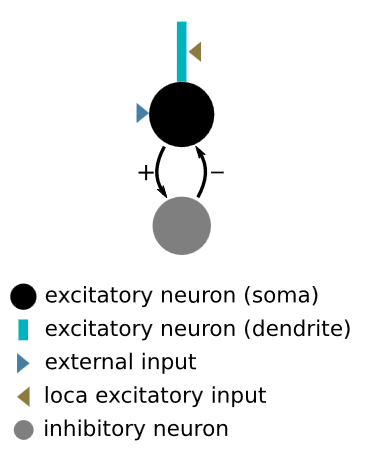

The postsynaptic potentials look as follows:

In [5]:
def run_active_dendrite_simulation(params):
    print("Running active dendrite simulation!")
    data = {}
    for i, name in enumerate(['ff', 'dendrite', 'ff_dendrite']): 
        print("Running experiment type: " + name)
        # init kernel
        seed = 1
        nest.ResetKernel()
        nest.Install(module_name)
        nest.set_verbosity(nest_verbosity)
        nest.SetKernelStatus({
            'resolution': params['dt'],
            'print_time': params['print_simulation_progress'],
            'local_num_threads': n_threads,
            'rng_seed': seed
        })
    
        data[name] = {}
    
        #############################
        # create and connect neurons
        # ---------------------------
    
        # create excitatory population
        exc_neuron = nest.Create(params['soma_model'], params=params['soma_params'])
    
        # create inhibitory population
        inh_neuron = nest.Create(params['inhibit_model'], params=params['inhibit_params'])
    
        # connect inhibition
        nest.Connect(exc_neuron, inh_neuron, syn_spec=params['syn_dict_ie'])
        nest.Connect(inh_neuron, exc_neuron, syn_spec=params['syn_dict_ei'])
    
        ######################
        # Input stream/stimuli
        #---------------------
        input_excitation = nest.Create('spike_generator', params={'spike_times': [params['soma_excitation_time']]})
        dendrite_excitation_1 = nest.Create('spike_generator', params={'spike_times': [params['dendrite_excitation_time']]})
        inhibition_excitation = nest.Create('spike_generator', params={'spike_times': [10.]})
    
        # excitation soma feedforward
        if name == 'ff' or name == 'ff_dendrite':
            nest.Connect(input_excitation, exc_neuron, syn_spec={'receptor_type': 1, 
                                                                 'weight': params['syn_dict_ex']['weight'], 
                                                                 'delay': params['syn_dict_ex']['delay']})

        # excitation dendrite 
        if name == 'dendrite' or name == 'ff_dendrite':
            nest.Connect(dendrite_excitation_1, exc_neuron, syn_spec={'receptor_type': 2, 
                                                                      'weight': params['syn_dict_edx']['weight'], 
                                                                      'delay': params['syn_dict_edx']['delay']})
    
        # record voltage inhibitory neuron 
        vm_inh = nest.Create('voltmeter', params={'record_from': ['V_m'], 'interval': 0.1})
        nest.Connect(vm_inh, inh_neuron)
    
        # record voltage soma
        vm_exc = nest.Create('voltmeter', params={'record_from': ['V_m'], 'interval': 0.1})
        nest.Connect(vm_exc, exc_neuron)
    
        active_dendrite_exc_mm = nest.Create('multimeter', params={'record_from': ['active_dendrite_readout', 'I_dend'], 'interval': 0.1})
        nest.Connect(active_dendrite_exc_mm, exc_neuron)
    
        # record spikes
        sd = nest.Create('spike_recorder')
        nest.Connect(exc_neuron, sd)
    
        # record inh spikes
        sd_inh = nest.Create('spike_recorder')
        nest.Connect(inh_neuron, sd_inh)
    
        print('### simulating network')
        nest.Prepare()
        nest.Run(100.)
    
        voltage_soma = nest.GetStatus(vm_exc)[0]['events']  
        active_dendrite = nest.GetStatus(active_dendrite_exc_mm)[0]['events']
        voltage_inhibit = nest.GetStatus(vm_inh)[0]['events'] 
        spikes_soma = nest.GetStatus(sd)[0]['events'] 
        spikes_inh = nest.GetStatus(sd_inh)[0]['events'] 
    
        data[name]['exc'] = voltage_soma 
        data[name]['exc_active_dendrite'] = active_dendrite 
        data[name]['inh'] = voltage_inhibit
        data[name]['spikes_exc'] = spikes_soma
        data[name]['spikes_inh'] = spikes_inh

    return data

data = run_active_dendrite_simulation(p)

Running active dendrite simulation!
Running experiment type: ff

Oct 16 18:53:40 Install [Info]: 
    loaded module nestml_53df85df034a42159911f33aede126f7_module
### simulating network
Running experiment type: dendrite
### simulating network
Running experiment type: ff_dendrite
### simulating network


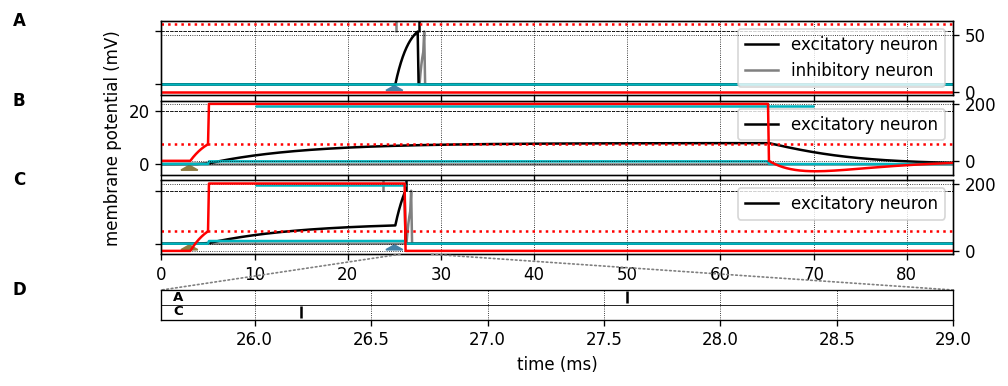

In [6]:
def plot_active_dendrite_simulation(params, data):
    
    def position_excitation_arrows(ax, soma_time, dendrite_time):
    
        arrow_width = 1.8
        arrow_height = 1.8
        y = -2.3
        
        # plot excitation arrows for panel A
        x = soma_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_somatic_input)
        ax[0].add_patch(t1)
    
        # plot excitation arrows for panel B
        x = dendrite_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_dAP_input)
        ax[1].add_patch(t1)
    
        # plot excitation arrows for panel C
        x = dendrite_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_dAP_input)
        ax[2].add_patch(t1)
    
        x = soma_time - arrow_width/2 
        pos = [x, y]
        X = np.array([pos, [pos[0]+arrow_width, pos[1]], [pos[0]+arrow_width/2, pos[1]+arrow_height]])
        t1 = plt.Polygon(X, color=color_somatic_input)
        ax[2].add_patch(t1)
    
    
    color_dAP_input = '#8e7c42ff'
    #color_somatic_input = '#0000ffff'
    color_somatic_input = '#4581a7ff'
    color_soma = '#000000ff'
    color_dAP = '#00B4BE' 
    color_inhibit = '#808080ff'  
    color_hrl = 'black'
    
    #color_somatic_spike = '#ff0000ff'
    color_somatic_spike = color_soma
    color_inh_spike = color_inhibit
    ms_spike = 7
    mew_spike = 1.5
    lw_vtheta = 0.5
    lw_dAP = 1.5
    lw_s = 1.5
    lw_i = 1.5
    
    # plot settings 
    fig_size = (6., 5)
    ymin = -4
    ymax = params['soma_params']['V_th'] + 4
    xmin = 0  
    xmax = 85
    label_pos = (-0.18, 1.)
    panel_labels = ['A', 'B', 'C']
    v_th=params['soma_params']['V_th'] 
    time_dAP = 10
    
    # set up the figure frame
    fig = plt.figure()
    gs = mpl.gridspec.GridSpec(5, 1, height_ratios=[15,15,15,5,6], bottom=0.1, right=0.95, top=0.93, wspace=0., hspace=0.1)
    left, bottom, width, height = [0.4, 0.1, 0.2, 0.2]
    axes = []
    
    for i, name in enumerate(['ff', 'dendrite', 'ff_dendrite']):
        ax = plt.subplot(gs[i,0])
        ax.text(label_pos[0], label_pos[1], panel_labels[i], transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', size=10, weight='bold')
        ax.plot(data[name]['exc']['times'], data[name]['exc']['V_m'], lw=lw_s, color=color_soma, zorder=2, label='excitatory neuron')  
        ax.plot(data[name]['exc_active_dendrite']['times'], data[name]['exc_active_dendrite']['active_dendrite_readout'], lw=lw_s, color=color_dAP)  
        
        ax_ = ax.twinx()
        ax_.plot(data[name]['exc_active_dendrite']['times'], data[name]['exc_active_dendrite']['I_dend'], lw=lw_s, color="red", label="I_dend")  
        ax_.plot((0., np.amax(data[name]['exc_active_dendrite']['times'])), 2*[p['soma_params']['theta_dAP']], c="red", linestyle=':')
                 
        ax.plot(data[name]['spikes_exc']['times'], (v_th+2)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
        ax.plot(data[name]['spikes_inh']['times'], (v_th+2)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
        ax.legend()
     
        # add dendritic action potential bar manually
        if name == 'dendrite': 
            ax.hlines(v_th+2, time_dAP, time_dAP+params['soma_params']['tau_dAP'], lw=lw_dAP, color=color_dAP)
    
        if name == 'ff_dendrite': 
            ax.hlines(v_th+2, time_dAP, data[name]['spikes_exc']['times'][0], lw=lw_dAP, color=color_dAP)
    
        # clamp voltage if doesn't reach the firing threshold
        if name == 'ff' or name == 'ff_dendrite': 
            max_volt = max(data[name]['inh']['V_m']) 
            max_volt_ind = np.where(data[name]['inh']['V_m']==max_volt)[0]
            data[name]['inh']['V_m'][max_volt_ind] = 20
    
        ax.plot(data[name]['inh']['times'], data[name]['inh']['V_m'], lw=lw_i, color=color_inhibit, zorder=1, label='inhibitory neuron') 
        ax.set_ylim([ymin, ymax])
        ax.set_xlim([xmin, xmax])
        ax.hlines(v_th, xmin, xmax, lw=lw_vtheta, color=color_hrl, linestyle='--')
    
        axes.append(ax)
    
    axes[1].set_ylabel('membrane potential (mV)')
    
    # set position of arrows
    position_excitation_arrows(axes, p['soma_excitation_time'], p['dendrite_excitation_time'])
    
    axes[0].legend(loc='center right')
    axes[0].set_yticklabels([])
    axes[0].set_xticklabels([])
    axes[1].set_xticklabels([])
    axes[2].set_yticklabels([])
    axes[2].set_xlabel('time (ms)')
    
    ########################################
    # plt spikes of A and B
    # --------------------------------------
    ax = fig.add_subplot(gs[i+1,0])
    plt.axis('off')
    
    ax = plt.subplot(gs[i+2,0])
    ax.text(label_pos[0], label_pos[1], 'D', transform=ax.transAxes, horizontalalignment='center', verticalalignment='center', size=10, weight='bold')
    
    xmin_d=25.6
    xmax_d=29
    
    ymin_d=0
    ymax_d=10
    
    name = 'ff'
    ax.plot(data[name]['spikes_exc']['times'], (3*ymax_d/4)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
    ax.plot(data[name]['spikes_inh']['times'], (3*ymax_d/4)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
    
    name = 'ff_dendrite'
    ax.plot(data[name]['spikes_exc']['times'], (ymax_d/4)*np.ones(len(data[name]['spikes_exc']['times'])), '|', c=color_somatic_spike, ms=ms_spike, mew=mew_spike)
    ax.plot(data[name]['spikes_inh']['times'], (ymax_d/4)*np.ones(len(data[name]['spikes_inh']['times'])), '|', c=color_inh_spike, ms=ms_spike, mew=mew_spike)
    ax.hlines(ymax_d/2, xmin, xmax, lw=0.5, color=color_hrl, linestyles='solid')
    
    ax.set_yticklabels([])
    ax.tick_params(left=False)
    ax.set_ylim([ymin_d, ymax_d])
    ax.set_xlim([xmin_d, xmax_d])
    ax.set_xlabel('time (ms)')
    
    ax.text(xmin_d+0.05, (3*ymax_d/4)-1, 'A', size=8, weight='bold')
    ax.text(xmin_d+0.05, (ymax_d/4)-1, 'C', size=8, weight='bold')
    
    ############################################################
    # add lines between the subplots showing the zoomed in area
    # ----------------------------------------------------------
    xy_C = (xmin_d,ymin)
    xy_D = (xmin_d,ymax_d)
    con = mpl.patches.ConnectionPatch(xyA=xy_C, xyB=xy_D, coordsA='data', coordsB='data', axesA=axes[-1], axesB=ax, color='grey', linestyle='dotted')
    ax.add_artist(con)
    
    xy_C = (xmax_d,ymin)
    xy_D = (xmax_d,ymax_d)
    con = mpl.patches.ConnectionPatch(xyA=xy_C, xyB=xy_D, coordsA='data', coordsB='data', axesA=axes[-1], axesB=ax, color='grey', linestyle='dotted')
    ax.add_artist(con)
    
    plt.savefig("/tmp/sequences1.png")

plot_active_dendrite_simulation(p, data)


Membrane-potential responses to an external input (blue
arrow, A), a strong dendritic input (brown arrow, B) triggering a dAP, and a
combination of both (C). Black and gray vertical bars mark times of excitatory
and inhibitory spikes, respectively. The horizontal dashed line marks the spike
threshold θE. The horizontal light blue lines depict the dAP plateau. D) Magnified
view of spike times from panels A and C. A dAP preceding the external input
(as in panel C) can speed up somatic, and hence, inhibitory firing, provided the
time interval between the dAP and the external input is in the right range.

## Experiment 2: synaptic plasticity dependence on dAP

We will now test the synaptic plasticity rule and the influence of homeostasis. Synapse growth is boosted if the
dAP activity $z_i(t)$ is below a target dAP activity $z^\ast$. Conversely, high dAP activity exceeding $z^\ast$ reduces the synapse growth.

In [7]:
def create_stdsp_dependence_on_third_factor_parameters():
    DELAY = 0.1
    
    p = para.ParameterSpace({})
    
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['print_simulation_progress'] = False         # print the time progress -- True might cause issues with Jupyter
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    # p['soma_params']['I_e'] = 0.        # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])

    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['convergence'] = 5
    p['pattern_size'] = 20       # sparse set of active neurons per subpopulation
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['permanence_min'] = 0.
    p['permanence_max'] = 8.
    p['calibration'] = 0.
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
    else:
        p['syn_dict_ee']['th_perm'] = 10.                    # synapse maturity threshold

    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    else:
        p['syn_dict_ee']['tau_plus'] = 20.                   # plasticity time constant (potentiation)
    
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.08                     # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace [pA]
    p['syn_dict_ee']['lambda_h'] = 0.014                        # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight
    p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
    p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.0015

    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    ## stimulus parameters
    p['DeltaT'] = 40.                               # inter-stimulus interval

    p['seed'] = 1          # rng seed
    
    return p

params = create_stdsp_dependence_on_third_factor_parameters() 

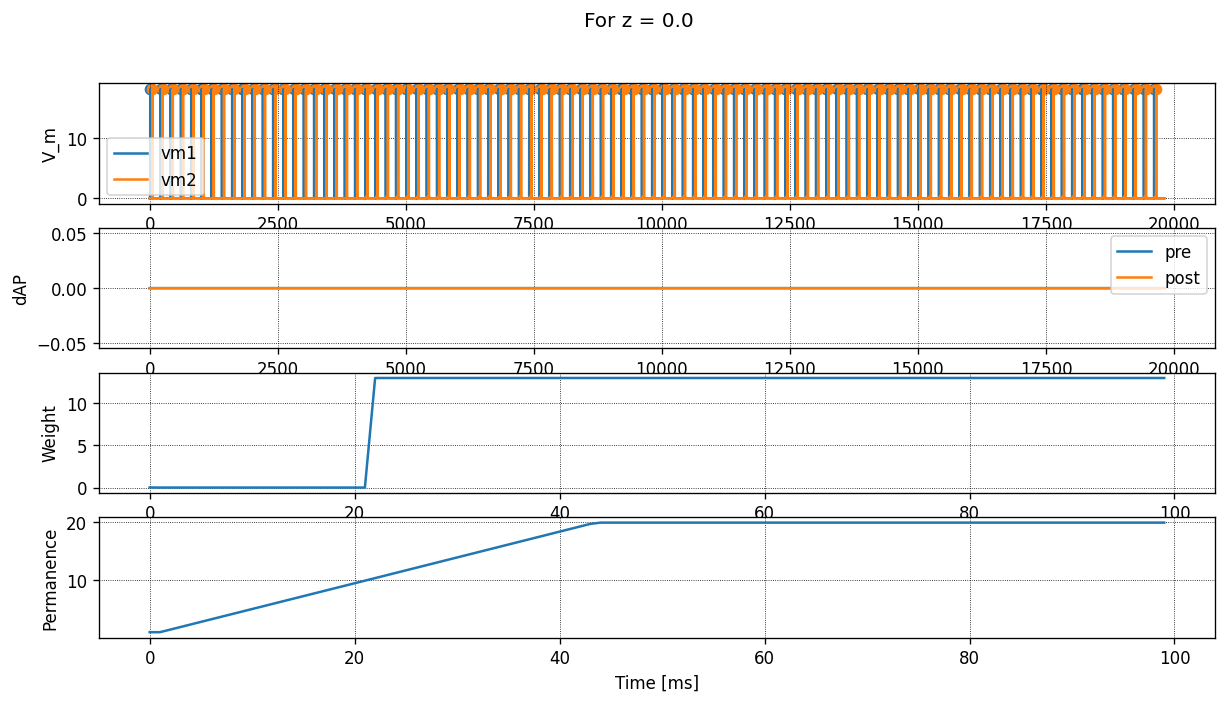

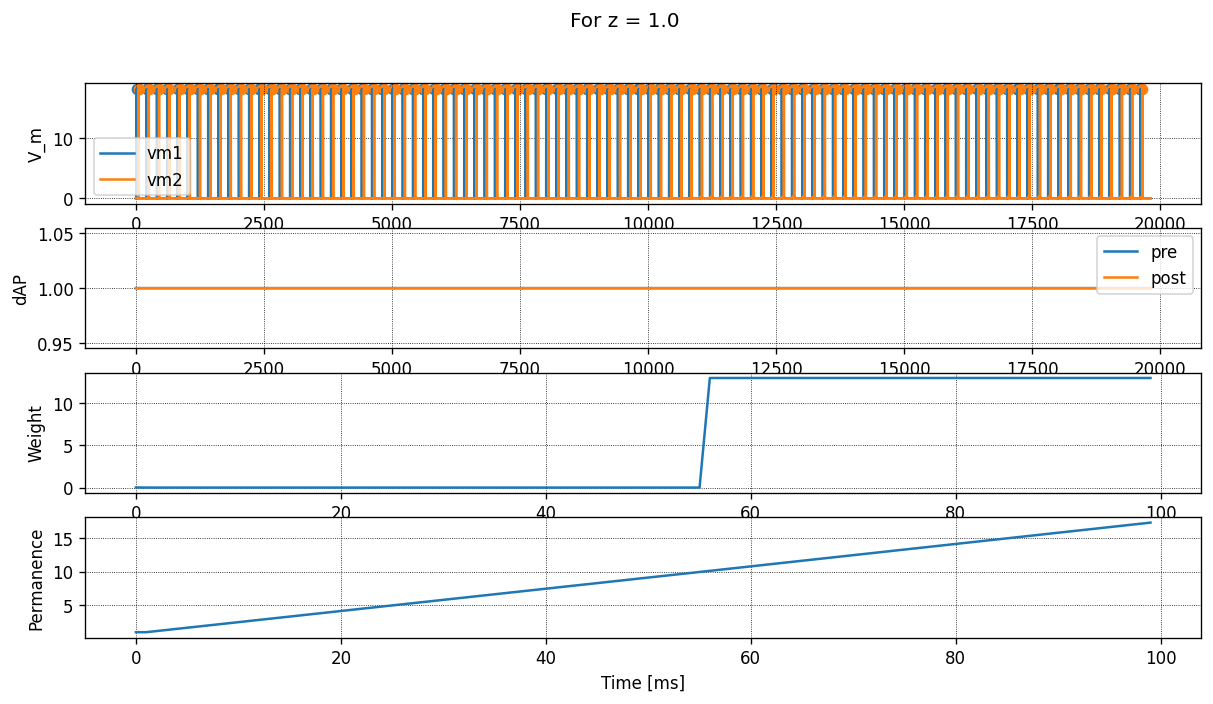

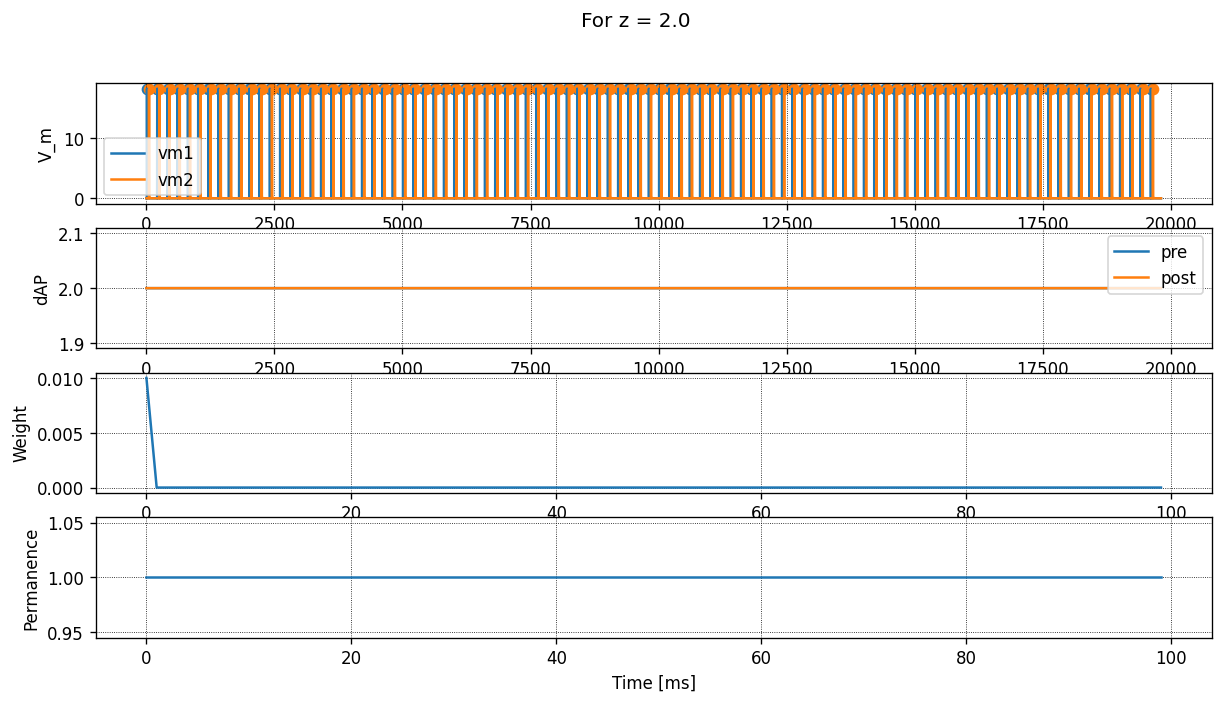

In [8]:
def simulate_stdsp_dependence_on_third_factor(params, z):
    
    nest.ResetKernel()
    nest.Install(module_name)
    nest.set_verbosity(nest_verbosity)
    nest.SetKernelStatus({
        'resolution': params['dt'],
        'print_time': False,
        'local_num_threads': n_threads,
        'rng_seed': params['seed']
    })
    
    neuron_1 = nest.Create(params['soma_model'], params=params['soma_params'])
    neuron_2 = nest.Create(params['soma_model'], params=params['soma_params'])
    
    # connect two neurons
    nest.Connect(neuron_1, neuron_2, syn_spec=params['syn_dict_ee'])
    
    # creation of spike generator
    time_neuron_1 = 10.
    time_neuron_2 = time_neuron_1 + params['DeltaT']
    
    training_steps = 100
    between_exc = 5*params['DeltaT']
    
    times_neuron_1 = [time_neuron_1+i*between_exc for i in range(training_steps)]
    times_neuron_2 = [time_neuron_2+i*between_exc for i in range(training_steps)]#[:10]
    
    # create the spike generators 
    # disable spike generator for the interval 'dis', to see the affect of stpd
    dis = 20
    spike_generator_1 = nest.Create('spike_generator', params={'spike_times': times_neuron_1})
    spike_generator_2 = nest.Create('spike_generator', params={'spike_times': times_neuron_2})
    
    # connect the spike generator 
    
    params['R_m_soma'] = params['soma_params']['tau_m'] / params['soma_params']['C_m']
    params['syn_dict_ex']['weight'] = psp_max_2_psc_max(params['J_EX_psp'], 
                                                               params['soma_params']['tau_m'], 
                                                               params['soma_params']['tau_syn1'], 
                                                               params['R_m_soma'])
    
    syn_dict_ff = {'receptor_type': 1, 'weight': params['syn_dict_ex']['weight'], 'delay': params['syn_dict_ex']['delay']}
    nest.Connect(spike_generator_1, neuron_1, syn_spec=syn_dict_ff)
    nest.Connect(spike_generator_2, neuron_2, syn_spec=syn_dict_ff)
    
    # record voltage neuron 1, neuron 2
    dap_mm_1 = nest.Create('multimeter', {"record_from": ["dAP_trace"]})
    nest.Connect(dap_mm_1, neuron_1)
    
    dap_mm_2 = nest.Create('multimeter', {"record_from": ["dAP_trace"]})
    nest.Connect(dap_mm_2, neuron_2)
    
    vm_1 = nest.Create('voltmeter')
    vm_2 = nest.Create('voltmeter')
    nest.Connect(vm_1, neuron_1)
    nest.Connect(vm_2, neuron_2)
    
    sd_1 = nest.Create('spike_recorder')
    nest.Connect(neuron_1, sd_1)
    
    sd_2 = nest.Create('spike_recorder')
    nest.Connect(neuron_2, sd_2)
    
    synColl = nest.GetConnections(synapse_model=synapse_model_name)
    assert len(synColl) == 1
    
    weights_cs = []
    permanences_cs = []
    weights = []
    permanences = []
    last_sim_time = 0

    spike_generator_1.origin = nest.GetKernelStatus('biological_time')
    spike_generator_2.origin = nest.GetKernelStatus('biological_time')

    # connect two neurons
    synColl.set({'permanence': 1.}) 

    for i in range(training_steps):

        # change toward using the weight recorder, example:
        #wr = nest.Create('weight_recorder')
        #nest.CopyModel('stdp_synapse', 'stdp_synapse_rec', {'weight_recorder': wr})
        nest.SetStatus(neuron_1, {'dAP_trace': z, 'evolve_dAP_trace': 0.})
        nest.SetStatus(neuron_2, {'dAP_trace': z, 'evolve_dAP_trace': 0.})

        # simulate the network
        sim_time = times_neuron_1[i] - last_sim_time 
        nest.Simulate(sim_time)
        last_sim_time = times_neuron_1[i]

        w_after = synColl.weight
        p_after = synColl.permanence
        weights.append(w_after)
        permanences.append(p_after)


    fig, ax = plt.subplots(figsize=(12, 6), nrows=4)
    ax[0].plot(nest.GetStatus(vm_1)[0]['events']["times"], nest.GetStatus(vm_1)[0]['events']["V_m"], label="vm1")
    max_V_m = np.amax(nest.GetStatus(vm_1)[0]['events']["V_m"])
    ax[0].scatter(nest.GetStatus(sd_1)[0]['events']['times'], max_V_m * np.ones_like(nest.GetStatus(sd_1)[0]['events']['times']))
    ax[0].plot(nest.GetStatus(vm_2)[0]['events']["times"], nest.GetStatus(vm_2)[0]['events']["V_m"], label="vm2")
    ax[0].scatter(nest.GetStatus(sd_2)[0]['events']['times'], max_V_m * np.ones_like(nest.GetStatus(sd_2)[0]['events']['times']))
    ax[0].set_ylabel("V_m")
    ax[0].legend()
    
    ax[1].plot(nest.GetStatus(dap_mm_1)[0]['events']["times"], nest.GetStatus(dap_mm_1)[0]['events']["dAP_trace"], label="pre")
    ax[1].plot(nest.GetStatus(dap_mm_2)[0]['events']["times"], nest.GetStatus(dap_mm_2)[0]['events']["dAP_trace"], label="post")
    ax[1].set_ylabel("dAP")
    ax[1].legend()
    
    ax[2].plot(weights)
    ax[2].set_ylabel("Weight")
    
    ax[3].plot(permanences)
    ax[3].set_ylabel("Permanence")
    
    ax[-1].set_xlabel("Time [ms]")

    fig.suptitle("For z = " + str(z))
    
    fig.savefig("/tmp/simulate_stdsp_dependence_on_third_factor_[z=" + str(z) + "].png", dpi=300)
    return weights, permanences

data = {"weights_cs": [], "permanences_cs": []}

zs = [0.,1.,2.]

for z in zs:
    weights_cs, permanences_cs = simulate_stdsp_dependence_on_third_factor(params, z)

    data["weights_cs"].append(weights_cs)
    data["permanences_cs"].append(permanences_cs)
    
data["zs"] = zs

---------------------------------


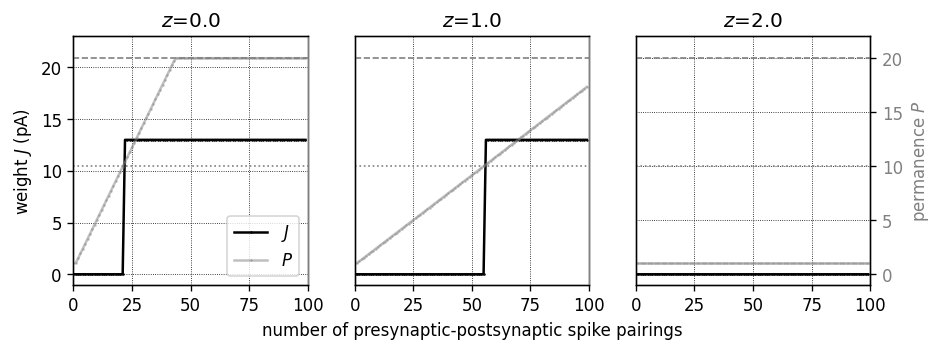

In [9]:
def plot_stdsp_dependence_on_third_factor(data, params):
    ms = 0.5
    alpha = 0.5
    lw_hline = 1.
    
    #################
    # visualize data
    # ---------------
    gs = mpl.gridspec.GridSpec(1, 3, right=0.92, left=0.09, bottom=0.2, top=0.89, wspace=0.2, hspace=0.2)
    
    # data for Ic=0
    # -------------
    ax1 = plt.subplot(gs[0,0])
    
    training_steps = len(data["weights_cs"][0])
    num_pulses = np.arange(training_steps)
    lns1 = ax1.plot(num_pulses, data["weights_cs"][0], '-o', ms=ms, color='black', label=r'$J$')
    
    #plt.ylabel('weight ($\mu$S)')
    ax1.set_xlim(0, training_steps)
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % zs[0])
    ax1.set_title(r'$z$=%0.1f' % data['zs'][0])
    ax1.set_ylabel(r'weight $J$ (pA)')
    
    ax2 = ax1.twinx()
    lns2 = ax2.plot(num_pulses, data["permanences_cs"][0], '-o', ms=ms, color='grey', alpha=alpha, label=r'$P$')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')

    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)

    
    ax2.tick_params(axis='y', labelcolor='grey')
    #ax2.set_yticklabels([])
    ax2.set_yticks([])
    ax2.spines['right'].set_color('grey')
    
    # add legends
    lns = [lns1[0],lns2[0]]
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower right')
    
    # data for Ic=1
    # -------------
    ax1 = plt.subplot(gs[0,1])
    
    ax1.plot(num_pulses, data["weights_cs"][1], '-o', ms=ms, color='black', label='weight')
    
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    ax1.set_xlim(0, training_steps)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % params['zs'][1])
    ax1.set_title(r'$z$=%0.1f' % data['zs'][1])
    ax1.set_xlabel('number of presynaptic-postsynaptic spike pairings')
    ax1.set_yticks([])
    
    ax2 = ax1.twinx()
    ax2.plot(num_pulses, data["permanences_cs"][1], '-o', ms=ms, color='grey', alpha=alpha, label='permanence')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')

    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)
    
    
    ax2.tick_params(axis='y', labelcolor='grey')
    ax2.set_yticks([])
    ax2.spines['right'].set_color('grey')
    
    # data for Ic=2
    # -------------
    ax1 = plt.subplot(gs[0,2])
    
    ax1.plot(num_pulses, data["weights_cs"][2], '-o', ms=ms, color='black', label='weight')
    
    ax1.set_ylim(-1, params["syn_dict_ee"]['Wmax']+10)
    ax1.set_xlim(0, training_steps)
    #ax1.set_title(r'dAP rate $\nu_\mathsf{d}$=%0.1f' % params['zs'][2])
    ax1.set_title(r'$z$=%0.1f' % data['zs'][2])
    ax1.set_yticks([])
    
    ax2 = ax1.twinx()
    ax2.plot(num_pulses, data["permanences_cs"][2], '-o', ms=ms, color='grey', alpha=alpha, label=r'$P$')
    if 'permanence_threshold' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_threshold'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if 'th_perm' in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['th_perm'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dotted')
    if "permanence_max" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['permanence_max'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')
        ax2.set_ylim(-1, params["syn_dict_ee"]['permanence_max']+2)

    if "Pmax" in params['syn_dict_ee'].keys():
        plt.hlines(params['syn_dict_ee']['Pmax'], 0, training_steps, lw=lw_hline, color='grey', linestyles='dashed')    
        ax2.set_ylim(-1, params["syn_dict_ee"]['Pmax']+2)

    ax2.tick_params(axis='y', labelcolor='grey')
    ax2.set_ylabel(r"permanence $P$", color="grey")
    #ax2.spines['right'].set_color('grey')
    
    print('---------------------------------')
    path = '.'
    fname = 'plasticity_dynamics'
    plt.savefig("/tmp/%s.png" % fname)

plot_stdsp_dependence_on_third_factor(data, params)

Plotted is the evolution of the synaptic permanence (gray) and weight (black) during repetitive presynaptic-postsynaptic spike pairing for different levels of the dAP activity. In the depicted example, presynaptic spikes precede the postsynaptic spikes by 40 ms for each spike pairing. Consecutive spike pairs are separated by a 200 ms interval. In each panel, the postsynaptic dAP trace is clamped at a different value: $z = 0$ (left), $z = 1$ (middle), and $z = 2$ (right). The dAP target activity is fixed at $z^\ast = 1$. The horizontal dashed and dotted lines mark the maximum permanence $P_\text{max}$ and the maturity threshold $\theta_P$, respectively.

## Experiment 3: Network sequence training and replay

Now that we have characterised the response of individual neurons and synapses, we take the next step and create the sequence learning network for a dictionary of 6 items (represented here as A, B, C, D, E and F).

In [10]:
def generate_sequences(params, fname):
    """Generate sequence of elements using three methods:
    1. randomly drawn elements from a vocabulary
    2. sequences with transition matrix
    3. higher order sequences: sequences with shared subsequences
    4. hard coded sequences

    Parameters
    ----------
    params : dict
        dictionary contains task parameters
    fname       : str

    Returns
    -------
    sequences: list
    test_sequences: list
    vocabulary: list
    """

    task_name = params['task_name']
 
    # set of characters used to build the sequences
    vocabulary = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                  'U', 'V', 'W', 'X', 'Y', 'Z'][:params['vocab_size']]
    sequences = []

    # create high order sequences, characters are drawn without replacement
    if task_name == "high_order":

        if (params['num_sequences'] % params['num_sub_seq'] != 0):
            raise ZeroDivisionError(
                'for high order sequences number of sequences needs ("num_sequences") to be divisible by num_sub_seq')

        num_sequences_high_order = int(params['num_sequences'] / params['num_sub_seq'])
        for i in range(num_sequences_high_order):
            characters_sub_seq = copy.copy(vocabulary)
            sub_seq = random.sample(characters_sub_seq, params["length_sequence"] - 2)
            for char in sub_seq:
                characters_sub_seq.remove(char)

            for j in range(params['num_sub_seq']):
                # remove the characters that were chosen for the end and the start of the sequence
                # this is to avoid sequences with adjacent letters of the same kind
                # we will add this feature to the code asap 
                end_char = random.sample(characters_sub_seq, 1)
                characters_sub_seq.remove(end_char[0])

                start_char = random.sample(characters_sub_seq, 1)
                characters_sub_seq.remove(start_char[0])

                sequence = start_char + sub_seq + end_char
                sequences.append(sequence)

    # randomly shuffled characters
    elif task_name == "random":
        # pick unique initial characters
        initial_characters = vocabulary.copy()
        np.random.shuffle(initial_characters)
        initial_characters = initial_characters[:params['num_sequences']]

        sequences = params['num_sequences'] * [None]
        for i in range(len(sequences)):
            # sequences[i] = params["length_sequence"] * [initial_characters[i]]
            # while repeated_characters(sequences[i]):
            #vocabulary_minus_initial = list(set(vocabulary) - set(initial_characters))
            sequences[i] = [initial_characters[i]] + list(np.random.choice(vocabulary, params["length_sequence"] - 1))
            
        # sequences = [np.random.choice(vocabulary, params["length_sequence"]) for _ in range(params['num_sequences'])]

    # create sequences using matrix transition 
    elif task_name == "structure":
        matrix_transition = defaultdict(list)
        for char in vocabulary:
            x = np.random.choice(2, len(vocabulary), p=[0.2, 0.8])
            matrix_transition[char] = x / sum(x)

        for _ in range(params['num_sequences']):
            sequence = random.sample(vocabulary, 1)
            last_char = sequence[-1]
            for _ in range(params["length_sequence"] - 1):
                sequence += np.random.choice(vocabulary, 1, p=matrix_transition[last_char])[0]
                last_char = sequence[-1]

            sequences += [sequence]
    else:
        assert task_name == "hard_coded"
        # hard coded sequences 
        task_type = params['task_type']
        if task_type == 1:
            sequences = [['A', 'D', 'B', 'E'], ['F', 'D', 'B', 'C']]
        elif task_type == 2:
            sequences = [['E', 'N', 'D', 'I', 'J'], ['L', 'N', 'D', 'I', 'K'], ['G', 'J', 'M', 'C', 'N'], 
                         ['F', 'J', 'M', 'C', 'I'], ['B', 'C', 'K', 'H', 'I'], ['A', 'C', 'K', 'H', 'F']]
        elif task_type == 3:
            sequences = [['E', 'N', 'D', 'I', 'J'], ['L', 'N', 'D', 'I', 'K'], ['G', 'J', 'M', 'E', 'N'], 
                         ['F', 'J', 'M', 'E', 'I'], ['B', 'C', 'K', 'B', 'I'], ['A', 'C', 'K', 'B', 'F']]
        elif task_type == 6:
            sequences = [['A', 'D', 'B', 'E'], ['F', 'D', 'B', 'C'], ['C', 'D', 'B', 'G']]
        else:
            #sequences = [['A', 'D', 'B', 'G', 'H', 'E'], ['F', 'D', 'B', 'G', 'H', 'C'], ['C', 'D', 'H', 'D', 'B', 'G']]
            sequences = [['A', 'D', 'B', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N','E'], ['F', 'D', 'B', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'C']]

    # test sequences used to measure the accuracy 
    test_sequences = sequences

    if params['store_training_data']:
        fname = 'training_data'
        fname_voc = 'vocabulary'
        print("\nSave training data to %s" % ( fname))
        np.save('%s' % ( fname), sequences)
        np.save('%s' % ( fname_voc), vocabulary)

    return sequences, test_sequences, vocabulary

In [11]:
def derived_parameters(params):
    """Set additional parameters derived from base parameters.

    A dictionary containing all (base and derived) parameters is stored as model attribute params

    Parameters
    ----------
    params:    dict
               Parameter dictionary
    """

    params = copy.deepcopy(params)

    synapse_model_name = params['syn_dict_ee']['synapse_model']

    # connection rules for EE connections
    params['conn_dict_ee'] = {}
    params['conn_dict_ee']['rule'] = params['rule']
    params['conn_dict_ee']['indegree'] = int(params['connection_prob'] *
                                                  params['M'] *
                                                  params['n_E'])
    params['conn_dict_ee']['allow_autapses'] = False
    params['conn_dict_ee']['allow_multapses'] = False

    # compute neuron's membrane resistance
    params['R_m_soma'] = params['soma_params']['tau_m'] / params['soma_params']['C_m']
    params['R_m_inhibit'] = params['inhibit_params']['tau_m'] / params['inhibit_params']['C_m']

    # compute psc max from the psp max
    params['J_IE_psp'] = 1.2 * params['inhibit_params']['V_th']         # inhibitory PSP as a response to an input from E neuron

    if params['evaluate_replay']:
        params['J_IE_psp'] /= params['n_E']
    else:
        params['J_IE_psp'] /= params['pattern_size']        

    params['syn_dict_ex']['weight'] = psp_max_2_psc_max(params['J_EX_psp'], params['soma_params']['tau_m'],
                                                   params['soma_params']['tau_syn1'], params['R_m_soma'])
    params['syn_dict_ie']['weight'] = psp_max_2_psc_max(params['J_IE_psp'], params['inhibit_params']['tau_m'],
                                                   params['inhibit_params']['tau_syn_ex'],
                                                   params['R_m_inhibit'])
    params['syn_dict_ei']['weight'] = psp_max_2_psc_max(params['J_EI_psp'], params['soma_params']['tau_m'],
                                                   params['soma_params']['tau_syn3'], params['R_m_soma'])

    # set initial weights (or permanences in the case of the structural synapse)
    import nest
    params['syn_dict_ee']['permanence'] = nest.random.uniform(min=params['permanence_min'], max=params['permanence_max']) 

    if "synapse_nestml" in synapse_model_name:
        params['syn_dict_ee']['dt_max'] = 2.*params['DeltaT']              # maximum time lag for the STDP window 
    else:
        params['syn_dict_ee']['dt_max'] = -2.*params['DeltaT']              # maximum time lag for the STDP window 
    params['DeltaT_seq'] = 2.5*params['DeltaT']                         # inter-sequence interval
    
    # clamp DeltaT_seq if it exceeds the duration of the dAP
    if params['DeltaT_seq'] < params['soma_params']['tau_dAP']:
        params['DeltaT_seq'] = params['soma_params']['tau_dAP']
     
    print('\n#### postsynaptic potential ####')
    print('PSP maximum J_EX psp:  %f mV' % params['J_EX_psp'])
    print('PSP maximum J_IE psp:  %f mV' % params['J_IE_psp'])
    print('PSP maximum J_EI psp:  %f mV' % params['J_EI_psp'])

    print('\n#### postsynaptic current ####')
    print('PSC maximum J_EX:  %f pA' % params['syn_dict_ex']['weight'])
    print('PSC maximum J_IE:  %f pA' % params['syn_dict_ie']['weight'])
    print('PSC maximum J_EI:  %f pA' % params['syn_dict_ei']['weight'])

    return params


###############################################################################
def parameter_set_list(P):
    """ Generate list of parameters sets
    
    Parameters
    ----------
    P : dict  
        parameter space 
    
    Returns
    -------
    l : list 
        list of parameter sets 
    """

    l = []
    for z in P.iter_inner():
        p = copy.deepcopy(dict(z))
        l.append(p)
        l[-1]['label'] = hashlib.md5(pformat(l[-1]).encode(
            'utf-8')).hexdigest()  ## add md5 checksum as label of parameter set (used e.g. for data file names) 

    return l



##############################################
def load_spike_data(label, skip_rows=3):
    """Load spike data from files.

    Parameters
    ---------
    label:          str
                    Spike file label (file name root).

    skip_rows:      int, optional
                    Number of rows to be skipped while reading spike files (to remove file headers). The default is 3.

    Returns
    -------
    spikes:   numpy.ndarray
              Lx2 array of spike senders spikes[:,0] and spike times spikes[:,1] (L = number of spikes).
    """

    # get list of files names
    files = []
    path="."
    for file_name in os.listdir(path):
        if file_name.endswith('.dat') and file_name.startswith(label):
            files += [file_name]
    files.sort()
    #files = [label + ".dat"]

    assert len(files) > 0, "No files of type '%s*.dat' found." % (label)

    # open spike files and read data
    spikes = []
    for file_name in files:
        try:
            spikes += [np.loadtxt('%s' % (file_name),skiprows=skip_rows)] ## load spike file while skipping the header 
        except:
            print('Error: %s' % sys.exc_info()[1])
            print('Remove non-numeric entries from file %s (e.g. in file header) by specifying (optional) parameter "skip_rows".\n' % (file_name))
    
    try:
        spikes = np.concatenate([spike for spike in spikes if spike.size>0])
    except:
        print("All files are empty")

#    # open spike files and read data
#    spikes = []
#    for file_name in files:
#        try:
#            spikes += [np.loadtxt('%s/%s' % (path, file_name),
#                                  skiprows=skip_rows)]  ## load spike file while skipping the header
#            print(spikes)
#        except:
#            print("Error: %s" % sys.exc_info()[1])
#            print(
#                "Remove non-numeric entries from file %s (e.g. in file header) by specifying (optional) parameter 'skip_rows'.\n" % (
#                    file_name))
#
#    spikes = np.concatenate(spikes)
#
    return spikes


###############################################################################
def load_data(fname):
    """Load data

    Parameters
    ----------
    path: str
    fname: str

    Returns
    -------
    data: ndarray
    """

    #TODO: this is temporary hack!
    try:
      data = np.load('%s.npy' % fname, allow_pickle=True).item()
    except:
      data = np.load('%s.npy' % fname, allow_pickle=True)

    return data


###############################################################################
def number_active_neurons_per_element(test_sequences, times_somatic_spikes, senders_somatic_spikes, excitation_times,
                                      fixed_somatic_delay):
    """
    Finds the active neurons of each element in the sequences and return their number

    Parameters
    ----------
    test_sequences         : list
    times_somatic_spikes   : ndarray
    senders_somatic_spikes : ndarray
    excitation_times       : list
    fixed_somatic_delay    : float

    Returns
    -------
    num_active_neurons_per_sequence : list
    """

    num_active_neurons_per_sequence = []
    end_iterations = 0

    assert len(excitation_times) >= 2, "excitation times need to contain at leasts 2 components"
    DeltaT = excitation_times[1] - excitation_times[0]

    # for each sequence in the test sequences
    for seq in test_sequences:
        start_iterations = end_iterations
        end_iterations += len(seq)
        num_active_neurons = {}

        # for each character in the sequence
        for k, (j, char) in enumerate(zip(range(start_iterations, end_iterations), seq)):
            indices_soma = np.where((times_somatic_spikes < excitation_times[j] + DeltaT) & 
                                    (times_somatic_spikes > excitation_times[j]))
            senders_soma = senders_somatic_spikes[indices_soma]

            num_active_neurons[char] = len(senders_soma)

        num_active_neurons_per_sequence.append(num_active_neurons)

    return num_active_neurons_per_sequence


###############################################################################
def measure_sequences_overlap(test_sequences, times_somatic_spikes, senders_somatic_spikes, excitation_times,
                              fixed_somatic_delay, number_training_episodes):
    """Finds the shared active neurons between the last sequence elements

    Parameters
    ----------
    test_sequences         : list
    times_somatic_spikes   : ndarray
    senders_somatic_spikes : ndarray
    excitation_times       : list
    fixed_somatic_delay    : float
    number_training_episodes : int

    Returns
    -------
    episodes_overlap       : list
    """

    sequences_active_neurons = [[] for _ in range(len(test_sequences))]
    end_iterations = 0
    episodes_overlap = []

    for training_episodes in range(number_training_episodes):
        # for each sequence in the test sequences
        for i, seq in enumerate(test_sequences):
            start_iterations = end_iterations
            end_iterations += len(seq)
            active_neurons = []

            # for each character in the sequence
            for k, (j, char) in enumerate(zip(range(start_iterations, end_iterations), seq)):
                indices_soma = np.where((times_somatic_spikes < excitation_times[j] + fixed_somatic_delay) & (
                        times_somatic_spikes > excitation_times[j]))
                senders_soma = senders_somatic_spikes[indices_soma]

                active_neurons.append(senders_soma)

            sequences_active_neurons[i] = active_neurons

        # compute overlap 
        co = 0
        sequences_overlap = []
        # TODO: use variable for test_sequences[0]
        for q in range(len(test_sequences[0])):
            overlap = [value for value in sequences_active_neurons[co][q] if
                       value in sequences_active_neurons[co + 1][q]]
            size_overlap = len(overlap)
            sequences_overlap.append(size_overlap)
        # TODO here the overlap is computed only between two sequences
        co += 2

        episodes_overlap.append(sequences_overlap)

    return episodes_overlap


###############################################################################
def compute_prediction_performance(somatic_spikes, dendriticAP, dendriticAP_recording_times,
                                   characters_to_subpopulations, test_seq, params):
    """Computes prediction performance including: error, false positive and false negative
    The prediction error is computed as the Euclidean distance between the target vector and the output vector for each last character `q` in a sequence.
    The output vector `o` is an M dimensional binary vector, where oi = 1 if the ith subpopulation is predicted, and oi= 0 else.
    A subpopulation is considered predicted if it contains at least `ratio_fp_activation*n_E` neurons with a dAP.
    
    Parameters
    ----------
    somatic_spikes   : ndarray
        Lx2 array of spike senders somatic_spikes[:,0] and spike times somatic_spikes[:,1]
                       (L = number of spikes).
    dendriticAP      : ndarray
        Lx3 array of current senders dendriticAP[:,0], current times dendriticAP[:,1],
        and current dendriticAP[:,2] (L = number of recorded data points).
    dendriticAP_recording_times  : list
        list of list containing times at which the dendritic current is recorded for a given 
        element in each sequence
    characters_to_subpopulations : dict
    test_seq  : list
        list of list containing sequence elements
    params    : dict
        parameter dictionary
    """

    errors = [[] for _ in range(len(test_seq))]
    false_positives = [[] for _ in range(len(test_seq))]
    false_negatives = [[] for _ in range(len(test_seq))]
    last_char_active_neurons = [[] for _ in range(len(test_seq))]
    last_char_active_dendrites = [[] for _ in range(len(test_seq))]

    seqs = copy.copy(test_seq)

    for seq_num, seq in enumerate(test_seq):
        recording_times = dendriticAP_recording_times[seq_num]

        for it, rc_time in enumerate(recording_times):

            # find dendritic action potentials (dAPs)
            idx_q = np.where((dendriticAP[:, 1] < rc_time + params['idend_record_time'] + 1.) & 
                               (dendriticAP[:, 1] > rc_time))[0]

            idx_dAP = np.where(dendriticAP[:, 2][idx_q] > params['soma_params']['I_p'] - 1.)[0]
            
            senders_dAP = dendriticAP[:, 0][idx_q][idx_dAP]
 
            subpopulation_senders_dAP = [int((s - 1) // params['n_E']) for s in senders_dAP]

            # find somatic action potentials
            idx_soma = np.where((somatic_spikes[:, 1] < rc_time + 2*params['DeltaT']) & 
                                (somatic_spikes[:, 1] > rc_time + params['DeltaT']))[0]
            senders_soma = somatic_spikes[:, 0][idx_soma]
            num_active_neurons = len(senders_soma)
            num_active_dendrites = len(senders_dAP)

            # create the target vector 
            excited_subpopulations = characters_to_subpopulations[seqs[seq_num][-1]]
            excited_subpopulations_prev = characters_to_subpopulations[seqs[seq_num][-2]]
            target = np.zeros(params['M'])
            target[excited_subpopulations] = 1

            # count false positives and construct the output vector
            output = np.zeros(params['M'])
            count_subpopulations = Counter(subpopulation_senders_dAP)
            counter_correct = 0

            #ratio_fn_activation = 0.8
            #ratio_fp_activation = 0.1
            ratio_fn_activation = 0.5
            ratio_fp_activation = 0.5

            for k, v in count_subpopulations.items():
                if k not in excited_subpopulations and v >= (ratio_fp_activation * params['pattern_size']):
                    #print('episode %d/%d count of a false positive %d, %d' % (it, len(recording_times), k, v))
                    output[k] = 1
                elif k in excited_subpopulations and v >= (ratio_fn_activation * params['pattern_size']):
                    counter_correct += 1

            # find false negatives
            if counter_correct == params['L']:
                output[excited_subpopulations] = 1
            #else:
            #    false_negative = 1

            error = 1/params['L'] * np.sqrt(sum((output - target) ** 2))
            false_positive = 1/params['L'] * sum(np.heaviside(output - target, 0))
            false_negative = 1/params['L'] * sum(np.heaviside(target - output, 0))

            # append errors, fp, and fn for the different sequences
            errors[seq_num].append(error)
            false_positives[seq_num].append(false_positive)
            false_negatives[seq_num].append(false_negative)
            last_char_active_neurons[seq_num].append(num_active_neurons)
            last_char_active_dendrites[seq_num].append(num_active_dendrites)

        print('#### Prediction performance ####')
        print('Sequence:', seqs[seq_num])
        print('Error:', errors[seq_num][-1])
        print('False positives:', false_positives[seq_num][-1])
        print('False negatives:', false_negatives[seq_num][-1])
        print('Number of active neurons in %s: %d' % (seqs[seq_num][-1], last_char_active_neurons[seq_num][-1]))
        print('Number of active dendrites in %s: %d' % (seqs[seq_num][-1], last_char_active_dendrites[seq_num][-1]))

    seq_avg_errors = np.mean(errors, axis=0)
    seq_avg_false_positives = np.mean(false_positives, axis=0)
    seq_avg_false_negatives = np.mean(false_negatives, axis=0)
    seq_avg_last_char_active_neurons = np.mean(last_char_active_neurons, axis=0)

    return seq_avg_errors, seq_avg_false_positives, seq_avg_false_negatives, seq_avg_last_char_active_neurons


###############################################################################
def hebbian_contribution(facilitate_factor, tau_plus, W_max, delta_t=40.):
    """Computes the increment of the facilitate function of the additive STDP 
    
    Parameters
    ----------
    facilitate_factor : float
    delta_T           : float
    tau_plus          : float
    W_max             : float

    Returns
    -------
    increment : float
    """

    increment = facilitate_factor * W_max * np.exp(-delta_t / tau_plus)
    #increment = facilitate_factor * W_max

    return increment


###############################################################################
def homeostasis_contribution(hs, Wmax=1, r_d=0, r_t=1):
    """ homeostasis plastic change

    Parameters
    ----------
    hs   : float
    r_d  : float            
    r_t  : float
    """

    return hs * (r_t - r_d) * Wmax


###############################################################################
def synaptic_plastic_change(facilitate_factor, tau_plus, w_max, hs, delta_t=40.):
    """ compute the plastic change due to Hebbian learning and homeostasis

    Parameters
    ----------
    facilitate_factor   : float
    tau_plus            : float
    w_max               : float
    hs                  : float
    delta_t             : float

    Returns
    -------
    w_tot               : float
    """

    w_inc = hebbian_contribution(facilitate_factor, tau_plus, w_max, delta_t)
    w_hom = homeostasis_contribution(hs, w_max)

    w_tot = w_inc + w_hom

    return w_tot

In [12]:
class Model:
    """Instantiation of the Spiking-TemporalMemory model and its PyNEST implementation.

    the model provides the following member functions: 

    __init__(parameters)
    create()
    connect()
    simulate(t_sim)

    In addition, each model may implement other model-specific member functions.
    """

    def __init__(self, params, sequences, vocabulary):
        """Initialize model and simulation instance, including

        1) parameter setting,
        2) generate sequence data,
        3) configuration of the NEST kernel,
        4) setting random-number generator seed, and

        Parameters
        ----------
        params:    dict
                   Parameter dictionary
        """

        print('\nInitialising model and simulation...')

        # set parameters derived from base parameters
        self.params = derived_parameters(params)
        print("Model parameters: " + str(self.params))

        # set network size
        self.num_subpopulations = params['M']
        self.num_exc_neurons = params['n_E'] * self.num_subpopulations

        # initialize RNG        
        np.random.seed(self.params['seed'])
        random.seed(self.params['seed'])

        # input stream: sequence data
        self.sequences = sequences
        self.vocabulary = vocabulary
        self.length_sequence = len(self.sequences[0])
        self.num_sequences = len(self.sequences)

        # initialize the NEST kernel
        self.__setup_nest()

        # get time constant for dendriticAP rate
        self.params['soma_params']['tau_h'] = self.__get_time_constant_dendritic_rate(
            calibration=self.params['calibration'])

    def __setup_nest(self):
        """Initializes the NEST kernel.
        """

        nest.ResetKernel()
        nest.Install(module_name)
        nest.set_verbosity(nest_verbosity)
        nest.SetKernelStatus({
            'resolution': self.params['dt'],
            'print_time': self.params['print_simulation_progress'],
            'local_num_threads': n_threads,
            'rng_seed': self.params['seed'],
            'dict_miss_is_error': True,
            'overwrite_files': self.params['overwrite_files'],
            'data_prefix': ''
        })

    def create(self):
        """Create and configure all network nodes (neurons + recording and stimulus devices)
        """

        print('\nCreating and configuring nodes...')

        # create excitatory population
        self.__create_neuronal_populations()

        # compute timing of the external inputs and recording devices
        # TODO: this function should probably not be part of the model
        excitation_times, excitation_times_neuron, idend_recording_times = self.__compute_timing_external_inputs(
                self.params['DeltaT'], self.params['DeltaT_seq'], self.params['DeltaT_cue'], 
                self.params['excitation_start'], self.params['time_dend_to_somatic'])

        # create spike generators
        self.__create_spike_generators(excitation_times_neuron)

        # create recording devices
        self.__create_recording_devices(excitation_times, idend_recording_times)

        # create weight recorder
        if self.params['active_weight_recorder']:
            self.__create_weight_recorder()

    def connect(self):
        """Connects network and devices
        """

        print('\nConnecting network and devices...')
        # TODO: take into account L (number of subpopulations per character) when connecting the network

        # connect excitatory population (EE)
        if self.params['load_connections']:
            print("\tLoading connections from file")
            self.__load_connections(label='ee_connections')
        else:
            print("\tCreating new random connections")
            self.__connect_excitatory_neurons()

            # connect inhibitory population (II, EI, IE)
        self.__connect_inhibitory_neurons()

        # connect external input
        self.__connect_external_inputs_to_subpopulations()

        # connect neurons to the spike recorder
        nest.Connect(self.exc_neurons, self.spike_recorder_soma)
        nest.Connect(self.exc_neurons, self.spike_recorder_soma_)
        nest.Connect(self.inh_neurons, self.spike_recorder_inh)
        nest.Connect(self.inh_neurons, self.spike_recorder_inh_)

        # connect multimeter for recording dendritic current
        if self.params['evaluate_performance']:
            nest.Connect(self.multimeter_idend_eval, self.exc_neurons)
            nest.Connect(self.multimeter_idend_eval_, self.exc_neurons)
            nest.Connect(self.multimeter_vm_eval_, self.exc_neurons)

        # connect multimeter for recording dendritic current from all subpopulations of the last trial
        if self.params['record_idend_last_episode']:
            nest.Connect(self.multimeter_idend_last_episode, self.exc_neurons)

        # set min synaptic strength
        self.__set_min_synaptic_strength()

    def simulate(self):
        """Run simulation.
        """

        # the simulation time is set during the creation of the network  
        if nest.Rank() == 0:
            print('\nSimulating {} ms.'.format(self.sim_time))

        nest.Simulate(self.sim_time)

    def __create_neuronal_populations(self):
        """'Create neuronal populations
        """

        # create excitatory population
        self.exc_neurons = nest.Create(self.params['soma_model'],
                                       self.num_exc_neurons,
                                       params=self.params['soma_params'])

        # create inhibitory population
        self.inh_neurons = nest.Create(self.params['inhibit_model'],
                                       self.params['n_I'] * self.num_subpopulations,
                                       params=self.params['inhibit_params'])

    def __create_spike_generators(self, excitation_times_neuron):
        """Create spike generators
        """

        excitation_times_soma, excitation_times_dend = excitation_times_neuron 

        self.input_excitation_soma = {}
        self.input_excitation_dend = {}
        for char in self.vocabulary:
            self.input_excitation_soma[char] = nest.Create('spike_generator')
            self.input_excitation_dend[char] = nest.Create('spike_generator')

        # set spike generator status with the above computed excitation times
        for char in self.vocabulary:
            nest.SetStatus(self.input_excitation_soma[char], {'spike_times': excitation_times_soma[char]})
            #print("For spike generator " + char + ", spike times = " + str(excitation_times_soma[char]))

        # this makes the first population in the sequence sparse
        if self.params['sparse_first_char']:
            first_chars = [char for seq in self.sequences for char in [seq[0]]]
            for char in first_chars:
                nest.SetStatus(self.input_excitation_dend[char], {'spike_times': excitation_times_dend[char]})

    def __create_recording_devices(self, excitation_times, idend_recording_times):
        """Create recording devices
        """
    
        # create a spike recorder for exc neurons
        self.spike_recorder_soma = nest.Create('spike_recorder', params={'record_to': 'ascii','label': 'somatic_spikes'})
        self.spike_recorder_soma_ = nest.Create('spike_recorder', params={'label': 'somatic_spikes'})

        # create a spike recorder for inh neurons
        self.spike_recorder_inh = nest.Create('spike_recorder', params={'record_to': 'ascii','label': 'inh_spikes'})
        self.spike_recorder_inh_ = nest.Create('spike_recorder', params={'label': 'inh_spikes'})

        # create multimeter to record dendritic currents of exc_neurons at the time of the last element in the sequence
        if self.params['evaluate_performance']:
            self.multimeter_idend_eval = nest.Create('multimeter', self.num_sequences,
                                                     params={'record_from': ['I_dend'],
                                                             'record_to': 'ascii',
                                                             'label': 'idend_eval'})
            
            self.multimeter_idend_eval_ = nest.Create('multimeter',
                                                     params={'record_from': ['I_dend'],
                                                             'label': 'idend_eval'})
            self.multimeter_vm_eval_ = nest.Create('multimeter',
                                                     params={'record_from': ['V_m'],
                                                             'label': 'vm_eval'})


            for i in range(self.num_sequences):
                idend_eval_spec_dict = {'offset': idend_recording_times[i][0] + self.params['idend_record_time'],
                                        'interval': idend_recording_times[i][1] - idend_recording_times[i][0]}
                nest.SetStatus(self.multimeter_idend_eval[i], idend_eval_spec_dict)

            #nest.SetStatus(self.multimeter_idend_eval_, {"interval": nest.GetKernelStatus()["resolution"]})
            #nest.SetStatus(self.multimeter_vm_eval_, {"interval": nest.GetKernelStatus()["resolution"]})

        # # create multimeter for recording dendritic current from all subpopulations of the last episode
        # if self.params['record_idend_last_episode']:
        #     self.multimeter_idend_last_episode = nest.Create('multimeter', params={'record_from': ['I_dend'],
        #                                                                            'record_to': 'ascii',
        #                                                                            'label': 'idend_last_episode'})

        #     if self.params['evaluate_replay']:
        #         idend_dict = {'interval': self.params['idend_recording_interval'],
        #                       'start': self.params['excitation_start'],
        #                       'stop': self.params['excitation_start'] \
        #                               + len(self.sequences) * self.params['DeltaT_cue']}

        #         nest.SetStatus(self.multimeter_idend_last_episode, idend_dict)
        #     else:
        #         number_elements_per_batch = sum([len(seq) for seq in self.sequences])
        #         idend_dict = {'interval': self.params['idend_recording_interval'],
        #                       'start': excitation_times[-number_elements_per_batch],
        #                       'stop': excitation_times[-1] + self.params['pad_time']}

        #         nest.SetStatus(self.multimeter_idend_last_episode, idend_dict)

        # create multimeter for recording dendritic current from all subpopulations of the last episode
        self.multimeter_idend_last_episode = nest.Create('multimeter', params={'record_from': ['I_dend'],
                                                                               'record_to': 'ascii',
                                                                               'label': 'idend_last_episode'})

        idend_dict = {'interval': self.params['idend_recording_interval'],
                      'start': 0.,
                      'stop': np.inf}

        nest.SetStatus(self.multimeter_idend_last_episode, idend_dict)

    def __create_weight_recorder(self):
        """Create weight recorder
        """

        self.wr = nest.Create('weight_recorder', {'record_to': 'ascii', 'label': 'weight_recorder'})
        #self.params['syn_dict_ee']['weight_recorder'] = self.wr
        nest.CopyModel(params['syn_dict_ee']['synapse_model'], 'stdsp_synapse_rec', {'weight_recorder': self.wr})
        self.params['syn_dict_ee']['synapse_model'] = 'stdsp_synapse_rec'

    def __compute_timing_external_inputs(self, DeltaT, DeltaT_seq, DeltaT_cue, excitation_start, time_dend_to_somatic):
        """Specifies the excitation times of the external input for each sequence element,
        subsequent sequence elements are presented  with  inter-stimulus interval DeltaT,  
        subsequent sequences are separated in time by an inter-sequence time interval DeltaT_seq,
        during the replay, the presented cues are seperated by an intercue time interval Delta_cue,
        In addition this function saves the times at which a dendritic current should be recorded,
        we don't want to record the dendritic current every time step as this consumes a lot of memory,
        so we instead record the dendritic current every 'episodes_to_testing' episodes,
        recording the dendritic current is essential for computing the prediction performance,
        the dendritic current is saved only at the time of last element in the sequence,
        this is because when assessing the prediction performance, we compute the prediction error 
        only with respect to the last element in the sequence
        
        Parameters
        ---------
        DeltaT               : float
        DeltaT_seq           : float
        DeltaT_cue           : float 
        excitation_start     : float
        time_dend_to_somatic : float

        Returns:
        --------
        excitation_times: list(float)
        excitation_times_soma: dict
        excitation_times_dend: dict
        idend_recording_times: dict
        """

        excitation_times_soma = defaultdict(list)
        excitation_times_dend = defaultdict(list)
        idend_recording_times = defaultdict(list)

        excitation_times = []
        sim_time = excitation_start
        for le in range(self.params['learning_episodes'] + 1):
            print("Learning episode: " + str(le) + " of " + str(self.params['learning_episodes'] + 1))

            for seq_num, sequence in enumerate(self.sequences):
                len_seq = len(sequence)
                for i, char in enumerate(sequence):

                    if i != 0:
                        sim_time += DeltaT

                    # store time of excitation for each symbol
                    excitation_times_soma[char] += [sim_time]
                    if i == 0:
                        excitation_times_dend[char] += [sim_time - time_dend_to_somatic]

                    # store dendritic spike times recording
                    if (i == len_seq - 2) and (le % self.params['episodes_to_testing'] == 0):
                        idend_recording_times[seq_num] += [sim_time]

                    excitation_times.append(sim_time)

                    if self.params['evaluate_replay']:
                        break

                # set timing between sequences
                if self.params['evaluate_replay']:
                    sim_time += DeltaT_cue
                else:
                    sim_time += DeltaT_seq

        # save data
        if self.params['evaluate_performance'] or self.params['evaluate_replay']:

            np.save('idend_recording_times', idend_recording_times)
            print("Saving idend_recording_times to " + 'idend_recording_times')
            np.save('excitation_times_soma',    excitation_times_soma)
            np.save('excitation_times', excitation_times)

        self.sim_time = sim_time
        return excitation_times, [excitation_times_soma, excitation_times_dend], idend_recording_times

    def __get_subpopulation_neurons(self, index_subpopulation):
        """Get neuron's indices (NEST NodeCollection) belonging to a subpopulation
        
        Parameters
        ---------
        index_subpopulation: int

        Returns
        -------
        NEST NodeCollection
        """

        neurons_indices = [int(index_subpopulation) * self.params['n_E'] + i for i in
                           range(self.params['n_E'])]

        return self.exc_neurons[neurons_indices]

    def __connect_excitatory_neurons(self):
        """Connect excitatory neurons
        """
        print("Conn exc neurons")
        print(self.params['conn_dict_ee'])
        print(self.params['syn_dict_ee'])
        nest.Connect(self.exc_neurons, self.exc_neurons, conn_spec=self.params['conn_dict_ee'],
                     syn_spec=self.params['syn_dict_ee'])
#        syn = nest.GetConnections(source=self.exc_neurons, target=self.exc_neurons, synapse_model=self.params["syn_dict_ee"]["synapse_model_name"])   # XXX
#        assert all(np.array(syn.weight) > 0)

    def __connect_inhibitory_neurons(self):
        """Connect inhibitory neurons
        """

        for k, subpopulation_index in enumerate(range(self.num_subpopulations)):
            # connect inhibitory population 
            subpopulation_neurons = self.__get_subpopulation_neurons(subpopulation_index)

            # connect neurons within the same mini-subpopulation to the inhibitory population
            nest.Connect(subpopulation_neurons, self.inh_neurons[k], syn_spec=self.params['syn_dict_ie'])

            # connect the inhibitory neurons to the neurons within the same mini-subpopulation
            nest.Connect(self.inh_neurons[k], subpopulation_neurons, syn_spec=self.params['syn_dict_ei'])

    def __connect_external_inputs_to_subpopulations(self):
        """Connect external inputs to subpopulations
        """

        # get input encoding
        self.characters_to_subpopulations = self.__stimulus_preference(fname='characters_to_subpopulations')

        # save characters_to_subpopulations for evaluation
        if self.params['evaluate_performance'] or self.params['evaluate_replay']:
            fname = 'characters_to_subpopulations'
            np.save(fname, self.characters_to_subpopulations)

        for char in self.vocabulary:
            subpopulations_indices = self.characters_to_subpopulations[char]

            # receptor type 1 correspond to the feedforward synapse of the 'iaf_psc_exp_multisynapse' model
            for subpopulation_index in subpopulations_indices:
                subpopulation_neurons = self.__get_subpopulation_neurons(subpopulation_index)
                nest.Connect(self.input_excitation_soma[char], subpopulation_neurons,
                             self.params['conn_dict_ex'], syn_spec=self.params['syn_dict_ex'])
                nest.Connect(self.input_excitation_dend[char], subpopulation_neurons,
                             self.params['conn_dict_edx'], syn_spec=self.params['syn_dict_edx'])

    def __stimulus_preference(self, fname='characters_to_subpopulations'):
        """Assign a subset of subpopulations to a each element in the vocabulary.

        Parameters
        ----------
        fname : str

        Returns
        -------
        characters_to_subpopulations: dict
        """

        if len(self.vocabulary) * self.params['L'] > self.num_subpopulations:
            raise ValueError(
                "num_subpopulations needs to be large than length_user_characters*num_subpopulations_per_character")

        characters_to_subpopulations = defaultdict(list)  # a dictionary that assigns mini-subpopulation to characters

        subpopulation_indices = np.arange(self.num_subpopulations)
        # permuted_subpopulation_indices = np.random.permutation(subpopulation_indices)
        permuted_subpopulation_indices = subpopulation_indices
        index_characters_to_subpopulations = []

        if self.params['load_connections']:
            # load connectivity: from characters to mini-subpopulations
            
            characters_to_subpopulations = load_input_encoding( fname)
        else:
            for char in self.vocabulary:
                # randomly select a subset of mini-subpopulations for a character
                characters_to_subpopulations[char] = permuted_subpopulation_indices[:self.params['L']]
                # delete mini-subpopulations from the permuted_subpopulation_indices that are already selected
                permuted_subpopulation_indices = permuted_subpopulation_indices[self.params['L']:]

        return characters_to_subpopulations

    def __set_min_synaptic_strength(self):
        """Set synaptic Wmin
        """

        connections = nest.GetConnections(synapse_model=self.params['syn_dict_ee']['synapse_model'])

        if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
            if "synapse_nestml" in synapse_model_name:
                connections.set({'permanence_min': connections.permanence})
            else:
                connections.set({'Pmin': connections.permanence})
        else:
            assert np.unique(connections.synapse_model)[0] == "static_synapse"
            connections.set({'Wmin': connections.weight})

    def save_connections(self, fname='ee_connections'):
        """Save connection matrix

        Parameters
        ----------
        label: str
            name of the stored file
        """

        print('\nSave connections to ' + '%s' % fname + '...')
        connections_all = nest.GetConnections(synapse_model=self.params['syn_dict_ee']['synapse_model'])

        connections = nest.GetStatus(connections_all, ['target', 'source', 'weight', 'permanence'])

        np.save(fname, connections)
        print('\n -> finished saving connections!')
        
    def __load_connections(self, label='ee_connections'):
        """Load connection matrix
        
        Parameters
        ----------
        label: str
            name of the stored file
        """

        assert self.params['syn_dict_ee']['synapse_model'] != 'stdsp_synapse_rec', "synapse model not tested yet"

        print('Load connections from ' + label + '...')
        conns = np.load('%s.npy' % label)
        conns_tg = [int(conn[0]) for conn in conns]
        conns_src = [int(conn[1]) for conn in conns]
        conns_weights = [conn[2] for conn in conns]

        if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
            conns_perms = [conn[3] for conn in conns]

        if self.params['evaluate_replay']:
            print("\tEvaluate replay, using static synapses")
            syn_dict = {'receptor_type': 2,
                        'delay': [self.params['syn_dict_ee']['delay']] * len(conns_weights),
                        'weight': conns_weights}
            nest.Connect(conns_src, conns_tg, 'one_to_one', syn_dict)
        else:
            print("\tUsing synapse model: " + self.params['syn_dict_ee']['synapse_model'])
            
            syn_dict_ee = copy.deepcopy(self.params['syn_dict_ee'])

            del syn_dict_ee['synapse_model']
            del syn_dict_ee['weight']
            del syn_dict_ee['receptor_type']
            if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
                del syn_dict_ee['permanence']

            nest.SetDefaults(self.params['syn_dict_ee']['synapse_model'], syn_dict_ee)

            if "stdsp" in self.params['syn_dict_ee']['synapse_model']:
                syn_dict = {'synapse_model': self.params['syn_dict_ee']['synapse_model'],
                            'receptor_type': 2,
                            'weight': conns_weights,
                            'permanence': conns_perms}
            else:
                syn_dict = {'synapse_model': self.params['syn_dict_ee']['synapse_model'],
                            'receptor_type': 2,
                            'weight': conns_weights}

            nest.Connect(conns_src, conns_tg, 'one_to_one', syn_dict)

    def __get_time_constant_dendritic_rate(self, DeltaT=40., DeltaT_seq=100., calibration=100, target_firing_rate=1):
        """Compute time constant of the dendritic AP rate,

        The time constant is set such that the rate captures how many dAPs a neuron generated
        all along the period of a batch
         
        Parameters
        ----------
        calibration : float
        target_firing_rate : float

        Returns
        -------
        float
           time constant of the dendritic AP rate
        """

        t_exc = ((self.length_sequence-1) * DeltaT + DeltaT_seq + calibration) \
                * self.num_sequences

        print("\nDuration of a sequence set %d ms" % t_exc)

        return target_firing_rate * t_exc


###########################################
def load_input_encoding( fname):
    """Load input encoding: association between sequence element and subpopulations

    Parameters
    ----------
    path: str
    fname: str

    Returns
    -------
    characters_to_subpopulations: dict
    """

    characters_to_subpopulations = load_data( fname)

    return characters_to_subpopulations

def clear_recorded_data():
    import glob
    files = glob.glob("somatic_spikes*dat")
    files += glob.glob("inh_spikes*dat")
    files += glob.glob("idend_eval*dat")
    files += glob.glob("idend_last_episode*dat")
    for file in files:
        try:
            os.remove(file)
            print(f"Removed: {file}")
        except Exception as e:
            print(f"Error removing {file}: {e}")


In [13]:
def create_sequence_learning_parameters():
    DELAY = 0.1

    p = para.ParameterSpace({})
    
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['print_simulation_progress'] = False         # print the time progress -- True might cause issues with Jupyter
    
    # neuron parameters of the excitatory neurons
    p['soma_model'] = neuron_model_name
    p['soma_params'] = {}
    p['soma_params']['C_m'] = 250.        # membrane capacitance (pF)
    p['soma_params']['E_L'] = 0.          # resting membrane potential (mV)
    # p['soma_params']['I_e'] = 0.        # external DC currents (pA)
    p['soma_params']['V_m'] = 0.          # initial potential (mV)
    p['soma_params']['V_reset'] = 0.      # reset potential (mV)
    p['soma_params']['V_th'] = 20.        # spike threshold (mV)
    p['soma_params']['t_ref'] = 10.       # refractory period
    p['soma_params']['tau_m'] = 10.       # membrane time constant (ms)
    p['soma_params']['tau_syn1'] = 2.     # synaptic time constant: external input (receptor 1)
    p['soma_params']['tau_syn2'] = 5.     # synaptic time constant: dendrtic input (receptor 2)
    p['soma_params']['tau_syn3'] = 1.     # synaptic time constant: inhibitory input (receptor 3)
    # dendritic action potential
    p['soma_params']['I_p'] = 200. # current clamp value for I_dAP during a dendritic action potenti
    p['soma_params']['tau_dAP'] = 60.       # time window over which the dendritic current clamp is active
    p['soma_params']['theta_dAP'] = 59.        # current threshold for a dendritic action potential
    
    p['soma_params']['I_dend_incr'] = 2.71 / (p['soma_params']['tau_syn2'])
    
    
    p['fixed_somatic_delay'] = 2          # this is an approximate time of how long it takes the soma to fire
                                          # upon receiving an external stimulus 
        
    # parameters for setting up the network  
    p['M'] = 6                   # number of subpopulations
    p['n_E'] = 150               # number of excitatory neurons per subpopulation
    p['n_I'] = 1                 # number of inhibitory neurons per subpopulation
    p['L'] = 1                   # number of subpopulations that represents one sequence element
    p['pattern_size'] = 20       # sparse set of active neurons per subpopulation
    
    # neuron parameters for the inhibitory neuron
    p['inhibit_model'] = 'iaf_psc_exp'
    p['inhibit_params'] = {}
    p['inhibit_params']['C_m'] = 250.         # membrane capacitance (pF)
    p['inhibit_params']['E_L'] = 0.           # resting membrane potential (mV)
    p['inhibit_params']['I_e'] = 0.           # external DC currents (pA)
    p['inhibit_params']['V_m'] = 0.           # initial potential (mV)
    p['inhibit_params']['V_reset'] = 0.       # reset potential (mV)
    p['inhibit_params']['V_th'] = 15.         # spike threshold (mV)
    p['inhibit_params']['t_ref'] = 2.0        # refractory period
    p['inhibit_params']['tau_m'] = 5.         # membrane time constant (ms)
    p['inhibit_params']['tau_syn_ex'] = .5    # synaptic time constant of an excitatory input (ms) 
    p['inhibit_params']['tau_syn_in'] = 1.65  # synaptic time constant of an inhibitory input (ms)
        
    # synaptic parameters
    p['J_EX_psp'] = 1.1 * p['soma_params']['V_th']     # somatic PSP as a response to an external input
    p['J_IE_psp'] = 1.2 * p['inhibit_params']['V_th']  # inhibitory PSP as a response to an input from E neuron
    
    # XXXXXXXXXXX
#     if params['evaluate_replay']:
#         params['J_IE_psp'] /= params['n_E']
#     else:
#         params['J_IE_psp'] /= params['pattern_size']
    p['J_IE_psp'] /= p['pattern_size']

    
    p['J_EI_psp'] = -2 * p['soma_params']['V_th']      # somatic PSP as a response to an inhibitory input
    p['convergence'] = 5
    
    # connection details
    p['rule'] = 'fixed_indegree'                          
    p['connection_prob'] = 0.2
    
    # parameters for ee synapses (stdsp)
    p['syn_dict_ee'] = {}
    p['permanence_min'] = 0.
    p['permanence_max'] = 8.

    p['calibration'] = 0.
    p['syn_dict_ee']['weight'] = 0.01                    # synaptic weight
    p['syn_dict_ee']['synapse_model'] = synapse_model_name  # synapse model
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_threshold'] = 10.                    # synapse maturity threshold
        p['syn_dict_ee']['tau_pre_trace'] = 20.                   # plasticity time constant (potentiation)
    else:
        p['syn_dict_ee']['th_perm'] = 10.                    # synapse maturity threshold
        p['syn_dict_ee']['tau_plus'] = 20.                   # plasticity time constant (potentiation)
    p['syn_dict_ee']['delay'] = 2.                       # dendritic delay 
    p['syn_dict_ee']['receptor_type'] = 2                # receptor corresponding to the dendritic input
    p['syn_dict_ee']['lambda_plus'] = 0.08               # potentiation rate
    p['syn_dict_ee']['zt'] = 1.                          # target dAP trace
    p['syn_dict_ee']['lambda_h'] = 0.014                 # homeostasis rate
    p['syn_dict_ee']['Wmax'] = 1.1 * p['soma_params']['theta_dAP'] / p['convergence']   # Maximum allowed weight
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['permanence_max'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['permanence_min'] = 1.                        # Minimum allowed permanence
    else:
        p['syn_dict_ee']['Pmax'] = 20.                       # Maximum allowed permanence
        p['syn_dict_ee']['Pmin'] = 1.                        # Minimum allowed permanence
    p['syn_dict_ee']['lambda_minus'] = 0.0015            # depression rate
    if "synapse_nestml" in synapse_model_name:
        p['syn_dict_ee']['dt_min'] = 4.                     # minimum time lag of the STDP window
    else:
        p['syn_dict_ee']['dt_min'] = -4.                     # minimum time lag of the STDP window
    
    # parameters of EX synapses (external to soma of E neurons)
    p['conn_dict_ex'] = {}
    p['syn_dict_ex'] = {}
    p['syn_dict_ex']['receptor_type'] = 1                    # receptor corresponding to external input
    p['syn_dict_ex']['delay'] = DELAY                        # dendritic delay
    p['conn_dict_ex']['rule'] = 'all_to_all'                 # connection rule
    
    # parameters of EdX synapses (external to dendrite of E neurons) 
    p['conn_dict_edx'] = {}
    p['syn_dict_edx'] = {}
    p['syn_dict_edx']['receptor_type'] = 2                    # receptor corresponding to the dendritic input
    p['syn_dict_edx']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_edx']['weight'] = 1.4 * p['soma_params']['theta_dAP']
    p['conn_dict_edx']['rule'] = 'fixed_outdegree'            # connection rule
    p['conn_dict_edx']['outdegree'] = p['pattern_size'] + 1   # outdegree
    
    # parameters for IE synapses 
    p['syn_dict_ie'] = {}
    #p['conn_dict_ie'] = {}
    p['syn_dict_ie']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ie']['delay'] = DELAY                        # dendritic delay
    #p['conn_dict_ie']['rule'] = 'fixed_indegree'             # connection rule
    #p['conn_dict_ie']['indegree'] = 5                        # indegree 
    
    # parameters for EI synapses
    p['syn_dict_ei'] = {}
    #p['conn_dict_ei'] = {}
    p['syn_dict_ei']['synapse_model'] = 'static_synapse'     # synapse model
    p['syn_dict_ei']['delay'] = DELAY                        # dendritic delay
    p['syn_dict_ei']['receptor_type'] = 3                    # receptor corresponding to the inhibitory input  
    #p['conn_dict_ei']['rule'] = 'fixed_indegree'             # connection rule
    #p['conn_dict_ei']['indegree'] = 20                       # indegree
    
    # stimulus parameters
    p['DeltaT'] = 40.                     # inter-stimulus interval
    p['excitation_start'] = 30.           # time at which the external stimulation begins
    p['time_dend_to_somatic'] = 20.       # time between the dAP activation and the somatic activation (only used if sparse_first_char is True)   
    p['DeltaT_cue'] = 80.                 # inter-cue interval during replay
    
    # simulation parameters 
    p['dt'] = 0.1                                  # simulation time resolution (ms)
    p['overwrite_files'] = True                    # if True, data will be overwritten,
                                                   # if False, a NESTError is raised if the files already exist
    p['seed'] = 111   # seed for NEST
    p['pad_time'] = 5.
    p['idend_recording_interval'] = 10 * p['dt']   # dendritic current recording resolution
    p['idend_record_time'] = 8.                    # time interval after the external stimulation at which the dendritic current is recorded
    p['evaluate_performance'] = True               # if turned on, we monitor the dendritic current at a certain time steps
                                                   # during the simulation. This then is used for the prediction performance assessment
    p['evaluate_replay'] = False                     
    p['record_idend_last_episode'] = True          # used for debugging, if turned on we record the dendritic current of all neurons
                                                   # this can consume too much memory
    p['store_connections'] = False              
    p['load_connections'] = False
    p['sparse_first_char'] = False                 # if turned on, the dAP of a subset of neurons in the subpopulation representing 
                                                   # first sequence elements is activated externally 
    p['active_weight_recorder'] = False            # if turned on, the weights are recorded every presynaptic spike
    
    # task parameters
    p['task'] = {}
    p['task']['task_name'] = 'hard_coded'          # name of the task
    p['task']['task_type'] = 1                     # this chooses between three hard coded sequence sets (see ./utils.py)
    p['task']['vocab_size'] = 6                    # vocabulary size
    p['task']['seed'] = 111                        # seed number
    p['task']['store_training_data'] = True        # if turned on, the sequence set is stored 
    
    p['learning_episodes'] = 100                    # total number of training episodes ('repetitions of the sequence sets')

    # ----------------------------------
    # task parameters: alternative
    # IMPOSSIBLE TASK! First and last elements overlap between different sequences
 
#     p['task'] = {}
#     p['task']['task_name'] = 'hard_coded'          # name of the task
#     p['task']['task_type'] = 6                     # this chooses between three hard coded sequence sets (see ./utils.py)
#     p['task']['vocab_size'] = 7                    # vocabulary size
#     p['task']['store_training_data'] = True        # if turned on, the sequence set is stored 
#     p['M'] = p['task']['vocab_size']               # number of subpopulations

#     p['learning_episodes'] = 50                    # total number of training episodes ('repetitions of the sequence sets')
    # ----------------------------------
    
    # setup the training loop  
    p['episodes_to_testing'] = 1                   # number of episodes after which we measure the prediction perfomance

    if "synapse_nestml" not in synapse_model_name:
        p['mu_plus']= 0.0 
        p['mu_minus']= 0.0
    
    return p


params = create_sequence_learning_parameters()

Generate the vocabulary and the sequences to learn:

In [14]:
sequences, _, vocabulary = generate_sequences(params['task'], fname="sequences")

print("Vocabulary: " + str(vocabulary))
print("Sequences: " + str(sequences))


Save training data to training_data
Vocabulary: ['A', 'B', 'C', 'D', 'E', 'F']
Sequences: [['A', 'D', 'B', 'E'], ['F', 'D', 'B', 'C']]


In [ ]:
def simulate_train_network(params):

    #############################################################
    # get network and training parameters 
    # ===========================================================
    p = copy.deepcopy(params)
    PS = copy.deepcopy(p)
    PL = parameter_set_list(PS) 
    params = PL[0]

    # start time 
    time_start = time.time()

    # ###############################################################
    # create network
    # ===============================================================
    model_instance = Model(params, sequences, vocabulary)
    time_model = time.time()
    model_instance.create()
    time_create = time.time()
    print("connect().....")
    model_instance.connect()
    print("connect()ed")
    time_connect = time.time()
    
    # store connections before learning
    print("Store connections.....")
    if params['store_connections']:
        model_instance.save_connections(fname='ee_connections_before')

    # ###############################################################
    # simulate the network
    # ===============================================================
    print("Simulating.....")
    clear_recorded_data()
    model_instance.simulate()
    time_simulate = time.time()

    print("Store connections.....")
    # store connections after learning
    if params['store_connections']:
        model_instance.save_connections(fname='ee_connections')

    print(
        '\nTimes of Rank {}:\n'.format(
            nest.Rank()) +
        '  Total time:          {:.3f} s\n'.format(
            time_simulate -
            time_start) +
        '  Time to initialize:  {:.3f} s\n'.format(
            time_model -
            time_start) +
        '  Time to create:      {:.3f} s\n'.format(
            time_create -
            time_model) +
        '  Time to connect:     {:.3f} s\n'.format(
            time_connect -
            time_create) +
        '  Time to simulate:    {:.3f} s\n'.format(
            time_simulate -
            time_connect))

    #
    # PLOTTING
    #

    nest.raster_plot.from_device(model_instance.spike_recorder_soma)
    fname_snip = str(time.time())
    plt.savefig("/tmp/nestml_raster_" + fname_snip + ".png")

    for gid in [1, 100, 200]:
        events = model_instance.spike_recorder_soma_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        spike_times = events["times"][idx]

        events = model_instance.multimeter_vm_eval_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        V_m = events["V_m"][idx]
        times = times[idx]
        assert len(times) > 100

        
        fig, ax = plt.subplots()
        ax.plot(times, V_m)
        ax.scatter(spike_times, np.zeros_like(spike_times), marker="D", alpha=.5)
        ax.set_ylabel("V_m")
        fig.savefig("/tmp/nestml_V_m_" + str(gid) + "_" + fname_snip + ".png")
    
        events = model_instance.multimeter_idend_eval_.get()["events"]
        times = events["times"]
        senders = events["senders"]
        idx = np.where(senders == gid)[0]
        I_dend = events["I_dend"][idx]
        times = times[idx]
        assert len(times) > 100
    
        fig, ax = plt.subplots()
        ax.plot(times, I_dend)
        ax.set_ylabel("I_dend")
        fig.savefig("/tmp/nestml_I_dend_"  + str(gid) + "_" + fname_snip + ".png")

    events = model_instance.spike_recorder_inh_.get()["events"]
    times = events["times"]
    senders = events["senders"]

    fig, ax = plt.subplots()

    for i, gid in enumerate(np.unique(senders)):
        idx = np.where(senders == gid)[0]
        spike_times = events["times"][idx]

        ax.scatter(spike_times, i * np.ones_like(spike_times), marker="D", alpha=.5)
    ax.set_ylabel("Inhibitory neuron idx")
    fig.savefig("/tmp/nestml_inhibitory_spikes_" + str(gid) + "_" + fname_snip + ".png")
        
    
    # print Ic
    #zs = np.array([nest.GetStatus(model_instance.exc_neurons)[i]['z'] for i in range(params['M']*params['n_E'])])
    #id_zs = np.where(zs>0.5)
    #print(zs[id_zs])

    # load spikes from reference data
    somatic_spikes = load_spike_data('somatic_spikes')
    idend_eval = load_spike_data('idend_eval')
    excitation_times = load_data('excitation_times')

    # get recoding times of dendriticAP
    idend_recording_times = load_data('idend_recording_times')
    characters_to_subpopulations = load_data('characters_to_subpopulations')

    #seq_avg_errors, seq_avg_false_positives, seq_avg_false_negatives, _ = compute_prediction_performance(somatic_spikes, idend_eval, idend_recording_times, characters_to_subpopulations, model_instance.sequences, model_instance.params)

    # get number of active neuron for each element in the sequence
    number_elements_per_batch = sum([len(seq) for seq in model_instance.sequences])
    start_time = excitation_times[-number_elements_per_batch] - 5 
    end_time = excitation_times[-1] + 5

    idx_times = np.where((np.array(excitation_times) > start_time) & (np.array(excitation_times) < end_time))  
    excitation_times_sel = np.array(excitation_times)[idx_times]

    num_active_neurons = number_active_neurons_per_element(model_instance.sequences, somatic_spikes[:,1], somatic_spikes[:,0], excitation_times_sel, params['fixed_somatic_delay'])

    print("\n##### testing sequences with number of somatic spikes ")
    count_false_negatives = 0
    for i, (sequence, seq_counts) in enumerate(zip(model_instance.sequences, num_active_neurons)): 
        seq = ''
        for j, (char, counts) in enumerate(zip(sequence, seq_counts)):
            seq += str(char)+'('+ str(seq_counts[char])+')'.ljust(2)

            if j != 0 and seq_counts[char] > 0.5*params['n_E']:
                count_false_negatives += 1

        print("sequence %d: %s" % (i, seq))   

    print("False negative counts", count_false_negatives)   

    print("\n### Plasticity parameters")
    print("lambda plus: %0.4f" % params['syn_dict_ee']['lambda_plus'])
    print("lambda homeostasis: %0.4f" % params['syn_dict_ee']['lambda_h'])
    print("lambda minus: %0.4f" % model_instance.params['syn_dict_ee']['lambda_minus']) 
    #print("inh factor:", params['inh_factor'])
    print("excitation step %0.1fms" % params['DeltaT']) #30-50  
    print("seed number: %d" % params['seed']) 
    print("number of learning episodes: %d" % params['learning_episodes'])

    return model_instance

params['store_connections'] = True    # N.B. this takes a very long time!

model_instance = simulate_train_network(params)


Initialising model and simulation...

#### postsynaptic potential ####
PSP maximum J_EX psp:  22.000000 mV
PSP maximum J_IE psp:  0.900000 mV
PSP maximum J_EI psp:  -40.000000 mV

#### postsynaptic current ####
PSC maximum J_EX:  4112.209148 pA
PSC maximum J_IE:  581.197349 pA
PSC maximum J_EI:  -12915.496650 pA
Model parameters: {'dt': 0.1, 'print_simulation_progress': False, 'soma_model': 'iaf_psc_exp_nonlineardendrite_neuron_nestml__with_stdsp_synapse_nestml', 'soma_params': {'C_m': 250.0, 'E_L': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 20.0, 't_ref': 10.0, 'tau_m': 10.0, 'tau_syn1': 2.0, 'tau_syn2': 5.0, 'tau_syn3': 1.0, 'I_p': 200.0, 'tau_dAP': 60.0, 'theta_dAP': 59.0, 'I_dend_incr': 0.542}, 'fixed_somatic_delay': 2, 'M': 6, 'n_E': 150, 'n_I': 1, 'L': 1, 'pattern_size': 20, 'inhibit_model': 'iaf_psc_exp', 'inhibit_params': {'C_m': 250.0, 'E_L': 0.0, 'I_e': 0.0, 'V_m': 0.0, 'V_reset': 0.0, 'V_th': 15.0, 't_ref': 2.0, 'tau_m': 5.0, 'tau_syn_ex': 0.5, 'tau_syn_in': 1.65}, 'J_EX_psp'

The initial sparse, random and immature network connectivity constitutes the skeleton on which the sequence-specific paths will be carved out during the learning process. Synaptic depression prunes connections not supporting the learned pattern, thereby reducing the chance of predicting wrong sequence items (false positives).

In [ ]:
def get_connection_matrix_from_fname(p, label):
    print('Load connections from ' + label + '...')
    conns = np.load('%s.npy' % label)
    conns_tg = [int(conn[0]) for conn in conns]
    conns_src = [int(conn[1]) for conn in conns]
    conns_weights = [conn[2] for conn in conns]

    min_gid = min(np.amin(conns_tg), np.amin(conns_src))
    max_gid = min(np.amax(conns_tg), np.amax(conns_src))

    total_n_E = p['n_E'] * p['M']
    A = np.zeros((total_n_E, total_n_E))
    for gid_src, gid_tg, w in zip(conns_src, conns_tg, conns_weights):
        A[gid_src - min_gid, gid_tg - min_gid] = w

    return A

def get_connection_matrix_from_model_instance(model_instance):
    min_gid = np.amin(model_instance.exc_neurons.tolist())
    max_gid = np.amax(model_instance.exc_neurons.tolist())

    total_n_E = len(model_instance.exc_neurons)
    A = np.zeros((total_n_E, total_n_E))

    conns = nest.GetConnections(source=model_instance.exc_neurons,
                                target=model_instance.exc_neurons)
  
    sources = list(conns.sources())
    targets = list(conns.targets())
    if "w" in conns.get().keys():
        A[sources - np.amin(sources), targets - np.amin(targets)] = list(conns.get("w"))
        
    elif "weight" in conns.get().keys():
        A[sources - np.amin(sources), targets - np.amin(targets)] = list(conns.get("weight"))

    return A

def plot_connection_matrix_from_model_instance(model_instance, A, fname_snip=""):

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(A)
    ax.set_ylabel("From neuron")
    ax.set_xlabel("To neuron")

    for subax in [ax.xaxis, ax.yaxis]:
        subax.set_major_locator(mpl.ticker.MultipleLocator(model_instance.params["n_E"]))
        subax.set_major_formatter(mpl.ticker.NullFormatter())
        subax.set_minor_locator(mpl.ticker.MultipleLocator(model_instance.params["n_E"], offset=model_instance.params["n_E"] / 2))
        subax.set_minor_formatter(mpl.ticker.FixedFormatter([""] + model_instance.vocabulary))

    fig.savefig("/tmp/W_model"+fname_snip+".png",dpi=300)

if params['store_connections']:
    A = get_connection_matrix_from_fname(params, "ee_connections_before")
    plot_connection_matrix_from_model_instance(model_instance, A, fname_snip="ee_connections_before")
else:
    "store_connections is False, skipping the plot"

To guarantee a successful learning, this initial skeleton must be neither too sparse nor too dense. Before learning, the presentation of a particular sequence element causes all neurons with the corresponding stimulus preference to reliably and synchronously fire a somatic action potential due to the strong, suprathreshold external stimulus. All other subpopulations remain silent. The lateral connectivity between excitatory neurons belonging to the different subpopulations is subject to a form of Hebbian structural plasticity. Repetitive and consistent sequential  presentation of sequence elements turns immature connections between successively activated subpopulations into mature connections, and hence leads to the formation of sequence-specific subnetworks.

In [ ]:
if params['store_connections']:
    A = get_connection_matrix_from_fname(params, "ee_connections")
    plot_connection_matrix_from_model_instance(model_instance, A, fname_snip="ee_connections")
else:
    "store_connections is False, skipping the plot"

At the beginning of the learning process, all neurons of a stimulated subpopulation collectively fire in response to the external input. Non-stimulated neurons remain silent. As the connectivity is still immature at this point, no dAPs are triggered in postsynaptic neurons, and, hence, no predictions are generated. As a consequence, the prediction error, the false-negative rate and the number of active neurons (in stimulated populations) are at their maximum, and the false positive rate is zero.

In [ ]:
def analyse_prediction_performance(params, model_instance, fname = 'prediction_performance'):
    PS = copy.deepcopy(params)
    PS_sel = copy.deepcopy(PS)
    compute_overlap = True
    
    PL = parameter_set_list(PS_sel)
    
    # get training data
    sequences = load_data('training_data')
    
    print("#### sequences used for training ### ")
    for i, sequence in enumerate(sequences): 
        seq = '' 
        for char in sequence:
            seq += str(char).ljust(2) 
        print("sequence %d: %s" % (i, seq))
    
    for cP, p in enumerate(PL):
    
        data = {}
    
        # get data path
        # load somatic spikes and dendritic current
        somatic_spikes = load_spike_data( 'somatic_spikes')
        idend_eval = load_spike_data('idend_eval')
    
        # load record and excitation times 
        print("Loading idend_recording_times from " + 'idend_recording_times')
        idend_recording_times = load_data('idend_recording_times')
        characters_to_subpopulations = load_data('characters_to_subpopulations')
        excitation_times = load_data('excitation_times')
    
        # compute prediction performance
        errors, false_positives, false_negatives, num_active_neurons = compute_prediction_performance(somatic_spikes, idend_eval, idend_recording_times, characters_to_subpopulations, sequences, p)
    
        if compute_overlap:
            # sequences overlap
            sequences_overlap = measure_sequences_overlap(sequences, somatic_spikes[:,1], somatic_spikes[:,0], excitation_times, p['fixed_somatic_delay'], p['learning_episodes'])
            data['overlap'] = sequences_overlap
    
        data['error'] = errors
        data['false_positive'] = false_positives
        data['false_negative'] = false_negatives
        data['rel_active_neurons'] = num_active_neurons/p['n_E']
        data['ep_num'] = p['episodes_to_testing'] * np.arange(int(p['learning_episodes']/p['episodes_to_testing'])+1)
    
        ep_to_sol = np.where(errors < 0.01)[0] 
        if len(ep_to_sol) == 0:
            print("number of episodes to convergence", p['learning_episodes'])
        else:    
            print("number of episodes to convergence", data['ep_num'][ep_to_sol][0])
    
        # save data
        print("Saving to " + fname)
        np.save(fname, data)

    return data

data = analyse_prediction_performance(params, model_instance)

In [ ]:
def plot_prediction_performance(fname = 'prediction_performance'):

    data = np.load("prediction_performance.npy", allow_pickle=True)
    data = data.item()
    
    
    fig, ax = plt.subplots(nrows=4)
    ax[0].plot(data["ep_num"], data["error"])
    ax[0].set_ylabel("error")

    ax[1].plot(data["ep_num"], data["false_positive"])
    ax[1].set_ylabel("fp")

    ax[2].plot(data["ep_num"], data["false_negative"])
    ax[2].set_ylabel("fn")

    ax[3].plot(data["ep_num"], data["rel_active_neurons"])
    ax[3].set_ylabel("activity")

    ax[-1].set_xlabel("Training episode")
    plt.savefig(fname)

plot_prediction_performance(fname='/tmp/prediction_performance.png')

During the first training episodes, the consistent collective firing of subsequently activated populations leads to the formation of mature connections as a result of the Hebbian structural plasticity. Upon reaching of a critical
number of mature synapse, first dAPs (predictions) are generated in postsynaptic cells.

As a consequence, the false negative rate decreases, and the stimulus responses become more sparse. At this early phase of the learning, the predictions of upcoming sequence elements are not yet context-specific (for sequence set I, non-sparse activity in “B” triggers a prediction in both “E” and “C”, irrespective of the context). Hence, the false-positive rate transiently increases. As the context specific connectivity is not consolidated at this point, more and more presynaptic subpopulations fail at triggering dAPs in their postsynaptic targets when they switch to sparse firing. Therefore, the false-positive rate decreases again, and the false-negative rate increases. In other words, there exists a negative feedback loop in the interim learning dynamics where the generation of predictions leads to an increase in sparsity which, in turn, causes prediction failures (and, hence, non-sparse firing). With an increasing number of training episodes, synaptic depression and homeostatic regulation increase context selectivity and thereby break this loop. Eventually, sparse firing of presynaptic populations is sufficient to reliably trigger
predictions in their postsynaptic targets. 

During the learning process, the number of mature connections grows to a point where the activation of a certain subpopulation by an external input generates dendritic action potentials (dAPs), a "prediction", in a subset of neurons in the subsequent subpopulation.

If the number of predictive neurons within a subpopulation is sufficiently large, their advanced spikes initiate a fast and strong inhibitory feedback to the entire subpopulation, and thereby suppress subsequent firing of non-predictive neurons in this population. Owing to this winner-take-all dynamics, the network generates sparse spiking in response to predicted stimuli, i.e., if the external input coincides with a dAP-triggered somatic depolarization. In the presence of a non-anticipated, non-predicted stimulus, the neurons in the corresponding subpopulation fire collectively in a non-sparse manner, thereby signaling a “mismatch”.

In [ ]:
def plot_network_dynamics(data, params, xmax=None, fname_snip=""):

    # get parameters 
    PS = copy.deepcopy(params)
    PS_sel = copy.deepcopy(PS)
    params = PS_sel
    num_neurons = params['M'] * params['n_E']
    
    print('#### sequences used for training ### ')
    for i, sequence in enumerate(data["sequences"]):
        seq = ''
        for char in sequence:
            seq += str(char).ljust(2)
        print('sequence %d: %s' % (i, seq))
    
    # get dendritic AP
    idx = np.where((data["idend"][:, 2] > params['soma_params']['theta_dAP']))[0]
    dendriticAP_currents = data["idend"][:, 2][idx]
    dendriticAP_times = data["idend"][:, 1][idx]
    dendriticAP_senders = data["idend"][:, 0][idx]
    
    # organize the characters for plotting purpose
    subpopulation_indices = []
    chars_per_subpopulation = []
    for char in data["vocabulary"]:
        # shift the subpopulation indices for plotting purposes 
        char_to_subpopulation_indices = data["characters_to_subpopulations"][char]
        subpopulation_indices.extend(char_to_subpopulation_indices)
    
        chars_per_subpopulation.extend(char * len(data["characters_to_subpopulations"][char]))
    
    shifted_subpopulation_indices = np.array(subpopulation_indices) + 0.5
    
    panel_label_pos = (-0.14,0.5)
    panel_labels = ['B', 'D', 'F']
    color_soma_spike = '#DB2763'
    color_dendrite_spike = '#00B4BE' 
    fc_bg = '#dcdcdc'
    fraction_active = 3
    delta_time = 5.
    ymin = -0.1
    ymax = 2
    xmin = 0
    master_file_name = 'replay_network_activity'
    
    start_time = 0.
    end_time = start_time + 150.
    
    if not xmax is None:
        end_time = max(end_time, xmax)
        
    # postprocess somatic spikes
    somatic_spikes_times = data["somatic_spikes"][:,1]#[idx_somatic_spikes]
    somatic_spikes_senders = data["somatic_spikes"][:,0]#[idx_somatic_spikes]
    initial_time = 0.#somatic_spikes_times[0]
    #somatic_spikes_times -= initial_time
    if xmax is None:
        xmax = somatic_spikes_times[-1] + delta_time

    # postporcess dendritic AP
    dAP_senders = dendriticAP_senders#[idx_dAP]
    dAP_currents = dendriticAP_currents#[idx_dAP]
    dAP_times = dendriticAP_times#[idx_dAP]
    #dAP_times -= initial_time

    idx_exc_times = np.where((data["excitation_times"] > start_time) & (data["excitation_times"] < end_time))
    excitation_times_sel = data["excitation_times"][idx_exc_times]

    
    # set up the figure frame
    fig, ax = plt.subplots(figsize=(12,4))

    # SOMA SPIKES
    senders_subsampled = somatic_spikes_senders
    line1 = ax.plot(somatic_spikes_times, somatic_spikes_senders, 'o', color=color_soma_spike, lw=0., ms=0.5, zorder=2)

    # DENDRITIC SPIKES
    for xx, sender in enumerate(senders_subsampled):
        idx_sub = np.where(dAP_senders == sender)
        line2 = plt.plot(dAP_times[idx_sub], dAP_senders[idx_sub], 'o', markersize=.5, color=color_dendrite_spike, zorder=1)
        #line2 = plt.scatter(dAP_times[idx_sub], dAP_senders[idx_sub], color=color_dendrite_spike, s=.5, zorder=1)

    for char in data["characters_to_time_excitation"].keys():
        char_stim_times = data["characters_to_time_excitation"][char]
        for t in char_stim_times:
            ax.text(t - 0.003, 10, char, horizontalalignment='center')
            arrow = mpl.patches.FancyArrowPatch(posA=(t, 0.), posB=(t, 10), arrowstyle='->', color='green', mutation_scale=10.)
            ax.add_patch(arrow)

    ax.set_xlim(-delta_time, xmax)
    ax.set_ylim(-10, num_neurons+10)

    ticks_pos = shifted_subpopulation_indices * params['n_E']
    ticks_label = chars_per_subpopulation
    subpopulation_indices_background = np.arange(params['M'])*params['n_E']

    ax.set_yticks(ticks_pos, ticks_label)
    ax.tick_params(labelbottom=False)

    for i in range(params['M'])[::2]:
        ax.axhspan(subpopulation_indices_background[i], subpopulation_indices_background[i]+params['n_E'], facecolor=fc_bg, zorder=0)

    ax.set_xlabel('time (ms)')
    ax.tick_params(labelbottom=True)

    fname = '/tmp/' + master_file_name + fname_snip + '.png'
    print("Saving figure to " + fname)
    fig.tight_layout()

    plt.savefig(fname, dpi=300)
    plt.close(fig)


def load_data_from_files():
    data = {}

    # get trained sequences and vocabulary
    data["sequences"] = load_data('training_data')
    data["vocabulary"] = load_data('vocabulary')

    # load spikes
    data["somatic_spikes"] = load_spike_data('somatic_spikes')
    data["idend"] = load_spike_data('idend_last_episode')

    # load spike recordings
    data["idend_recording_times"] = load_data('idend_recording_times')
    data["characters_to_subpopulations"] = load_data('characters_to_subpopulations')
    data["characters_to_time_excitation"] = load_data('excitation_times_soma')

    # load excitation times
    data["excitation_times"] = load_data('excitation_times')

    return data

data = load_data_from_files()
plot_network_dynamics(data, params, fname_snip="_during_training")


In [ ]:
A = get_connection_matrix_from_model_instance(model_instance)
plot_connection_matrix_from_model_instance(model_instance, A, fname_snip="after_training")

## Experiment 4: Autonomous replay of sequences

We can cue the network to recall an entire sequence by presenting only the first item in the sequence. To set up the network into this autonomous replay mode, the somatic firing threshold voltage, as well as the dAP threshold voltage are lowered.

In [ ]:
params = create_sequence_learning_parameters()
DELAY = 0.1
params['record_idend_last_episode'] = True
params['syn_dict_ei']['delay'] = 2*DELAY

In [ ]:
def run_replay_experiment(PS):
    PS = copy.deepcopy(PS)
    PL = parameter_set_list(PS) 
 
    array_id = 0

    params = PL[array_id]
    params['learning_episodes'] = 4 
    params['episodes_to_testing'] = 1
    params['load_connections'] = True
    params['evaluate_replay'] = True
    params['evaluate_performance'] = False
    params['store_training_data'] = False
    params['DeltaT_cue'] = 250.
    
    
    # record dendritic current for only DeltaT=40.
    # record for the sequence replay plot
    if params['DeltaT'] == 40.:
        params['record_idend_last_episode'] = True

    params['soma_params']['V_th'] *= 0.25
    # imporant: the adjustment of theta_dAP is only important for large interstimulus intervals (above 75ms)
    # As the potentiation is small for large (\DeltaT), during the predictive mode the total PSC is barely above the dAP.
    # During the replay mode, the dispersion in the firing times causes the postsynaptic neurons to not have sufficient PSC to generate dAPs.
    # Adjusting theta_dAP addresses this issue
    # there might be other solutions such as increasing the number of learning episodes or adjusting the learning rates
    params['soma_params']['theta_dAP'] *= 0.7

    # disable learning
    params['syn_dict_ee']['synapse_model'] = 'static_synapse'     # synapse model
    
    params['idend_recording_interval'] = params['dt']

    # start time 
    time_start = time.time()

    # ###############################################################
    # create network
    # ===============================================================
    model_instance = Model(params, sequences, vocabulary)
    time_model = time.time()

    model_instance.create()
    time_create = time.time()

    # ###############################################################
    # connect the netwok
    # ===============================================================
    model_instance.connect()
    time_connect = time.time()

    # ###############################################################
    # train the network
    # ===============================================================
    # simulate network     
    print("Running replay experiment...")
    clear_recorded_data()
    model_instance.simulate()
    time_simulate = time.time()
    
    A = get_connection_matrix_from_model_instance(model_instance)
    plot_connection_matrix_from_model_instance(model_instance, A, fname_snip="after_replay")

    print(
        '\nTimes of Rank {}:\n'.format(
            nest.Rank()) +
        '  Total time:          {:.3f} s\n'.format(
            time_simulate -
            time_start) +
        '  Time to initialize:  {:.3f} s\n'.format(
            time_model -
            time_start) +
        '  Time to create:      {:.3f} s\n'.format(
            time_create -
            time_model) +
        '  Time to connect:     {:.3f} s\n'.format(
            time_connect -
            time_create) +
        '  Time to simulate:    {:.3f} s\n'.format(
            time_simulate -
            time_connect))

run_replay_experiment(params)


When exposing a network that has learned the two
sequences {A,D,B,E} and {F,D,B,C} to the elements “A” and “F”, different subsets of
neurons are activated in “D” and “B”. By virtue of these sequence specific activation
patterns, stimulation by {A,D,B} or {F,D,B} leads to correct predictions “E” or “C”,
respectively

In [ ]:
data = load_data_from_files()
plot_network_dynamics(data, params, fname_snip="replay")

In [ ]:
def replay_analysis(PS):
    ##################################################################
    # function to return key for any value 
    def get_key(my_dict, val): 
        for key, value in my_dict.items(): 
            if val == value: 
                return key 
    
        return "key doesn't exist"

    PS = copy.deepcopy(PS)
    
    # parameters list
    PL = parameter_set_list(PS) 
    
    #TODO: use argparse with default values
    try: 
        batch_id=int(sys.argv[1])
        batch_array_id=int(sys.argv[2])
        JOBMAX=int(sys.argv[3])
        array_id=batch_id*JOBMAX+batch_array_id
    except:
        array_id = 0
    
    params = PL[array_id]
    
    # get parameters 
    #PS, PS_path = get_parameter_set(path_dict)
    num_neurons = params['M'] * params['n_E']
    num_trials = 10
    
    # get trained sequences
    sequences = load_data( 'training_data')
    len_seqs = len(sequences)
    print("len_seqs = " + str(len_seqs))
    
    # load spiking data
    somatic_spikes = load_spike_data('somatic_spikes')
    
    # get excitation times 
    characters_to_subpopulations = load_data('characters_to_subpopulations')
    excitation_times = load_data('excitation_times')
    
    #################################
    # Postprocess data
    # -------------------------------
    
    sequences_active_neurons = [[] for _ in range(len_seqs)]
    sequences_firing_times = [[] for _ in range(len_seqs)]
    replay_durations = []
    #for num_trials in range(params['learning_episodes']-2):
    for id_trial in range(num_trials-1): 
    
        firing_times = defaultdict(list)
        active_neurons = defaultdict(list)
    
        for k, seq in enumerate(sequences):
    
            # select data for first sequence
            start_time = excitation_times[id_trial*len_seqs+k] 
            end_time = excitation_times[id_trial*len_seqs+1+k]
    
            # select somatic spikes to process
            ind_somatic = np.where((somatic_spikes[:,1] > start_time) & (somatic_spikes[:,1] < end_time))
    
            times_somatic_spikes = somatic_spikes[:,1][ind_somatic]
            senders_somatic_spikes = somatic_spikes[:,0][ind_somatic]
            initial_time = times_somatic_spikes[0]
            times_somatic_spikes -= initial_time
            #xmax = times_somatic_spikes[-1] + pad_time
    
            for index_sender in senders_somatic_spikes:
    
                num_subpopulation = int((index_sender-1) / params['n_E'])
    
                index_time = np.where(senders_somatic_spikes == index_sender)
                firing_times[get_key(characters_to_subpopulations, num_subpopulation)].append(times_somatic_spikes[index_time][0])
                active_neurons[get_key(characters_to_subpopulations, num_subpopulation)].append(index_sender)
    
        first_letter_mean_firing_times = np.mean(firing_times[sequences[0][0]])
        last_letter_mean_firing_times = np.mean(firing_times[sequences[0][-1]])
    
        replay_duration = last_letter_mean_firing_times - first_letter_mean_firing_times
        replay_durations.append(replay_duration)
    
    data = {}
    data['mean_replay_duration'] = np.mean(replay_durations)
    data['std_replay_duration'] = np.std(replay_durations)
    print('mean replay duration:', data['mean_replay_duration'])
    print('std replay duration:', data['std_replay_duration'])
    
    print('--------------------------------------------------')
    fname = 'replay_duration' 
    np.save(fname, data)

#replay_analysis(params)

Conclusions/further steps
-------------------------

- Playback speed experiments: dAPs equip neurons with a third type of state (next to the quiescent and the firing
    state): the predictive state, i.e., a long lasting (∼50-200 ms ) strong depolarization of
    the soma. Due to the prolonged depolarization of the soma, the inter-stimulus interval
    can be much larger than the synaptic time constants and delays.
    
    Try to reproduce Fig. 10 from [2].

Acknowledgements
------------------

Many thanks to Younes Bouhadjar for his work and fruitful discussions on the sequence learning network.

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).


References
----------

[1] Younes Bouhadjar. A brain inspired sequence learning algorithm and foundations of a memristive hardware implementation Younes Bouhadjar (PhD thesis, RWTH Aachen). https://doi.org/10.18154/RWTH-2023-03627

[2] Bouhadjar Y, Wouters DJ, Diesmann M, Tetzlaff T (2022) Sequence learning, prediction, and replay in networks of spiking neurons. PLoS Comput Biol 18(6): e1010233. https://doi.org/10.1371/journal.pcbi.1010233


Copyright
------------

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST. If not, see http://www.gnu.org/licenses/.

